In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-16 11:42:05.001770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(iii) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/Device-30(iii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.0859375-0.1015625j  0.140625 -0.0390625j  0.15625  +0.0234375j ...
  0.1484375-0.015625j   0.0078125+0.j        -0.046875 -0.0546875j]
2048
81192
(2048, 81192)
[0.02548666 0.01464884 0.00464241 ... 0.00497836 0.00486453 0.01513299]
0
(10000, 2048)
(10000,)
[ 0.015625 -0.0390625j -0.0078125+0.0234375j -0.0625   -0.046875j  ...
 -0.015625 -0.03125j   -0.03125  +0.0390625j  0.0234375-0.0390625j]
2048
94064
(2048, 94064)
[0.02545975 0.01511589 0.004805   ... 0.00455836 0.00458218 0.01531063]
1
(20000, 2048)
(20000,)
[-0.0546875-0.03125j    0.0234375+0.0078125j  0.0390625-0.0234375j ...
 -0.0078125+0.109375j   0.0625   -0.0234375j -0.0390625+0.015625j ]
2048
73803
(2048, 73803)
[0.0254731  0.01545307 0.00518516 ... 0.00449251 0.00567295 0.01493643]
2
(30000, 2048)
(30000,)
[ 0.03125  +0.0078125j  0.015625 +0.0078125j  0.0078125-0.0234375j ...
 -0.140625 +0.0859375j  0.0625   -0.0078125j -0.0390625-0.0234375j]
2048
88580
(2048, 88580)
[0.02542135 0.01478643 0.00474003 ... 0.00453174 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(iii) dataset 

In [5]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-16 11:48:08.103320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 4ms/step - loss: 5.4449 - accuracy: 0.1309
test loss, test acc: [5.444907188415527, 0.13093750178813934]


In [7]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[7 7 7 ... 2 5 2]
7
[[   0    0 7302    4   27 2473  191    3]
 [   0    9 6249    0    3 3566   13  160]
 [   0    0 4689   10   29 5164   91   17]
 [   0    0 5509    3    6 4355   79   48]
 [   0    0 5103    3   11 4790   79   14]
 [   4    0 4386    7   61 5438   93   11]
 [   0    0 5419    0    2 4167  204  208]
 [   1    0 5695    0    4 4023  156  121]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       1.00      0.00      0.00     10000
           2       0.11      0.47      0.17     10000
           3       0.11      0.00      0.00     10000
           4       0.08      0.00      0.00     10000
           5       0.16      0.54      0.25     10000
           6       0.23      0.02      0.04     10000
           7       0.21      0.01      0.02     10000

    accuracy                           0.13     80000
   macro avg       0.24      0.13  

Test Accuracy:0.1309375


Text(0.5, 1.0, 'Accuracy:0.131')

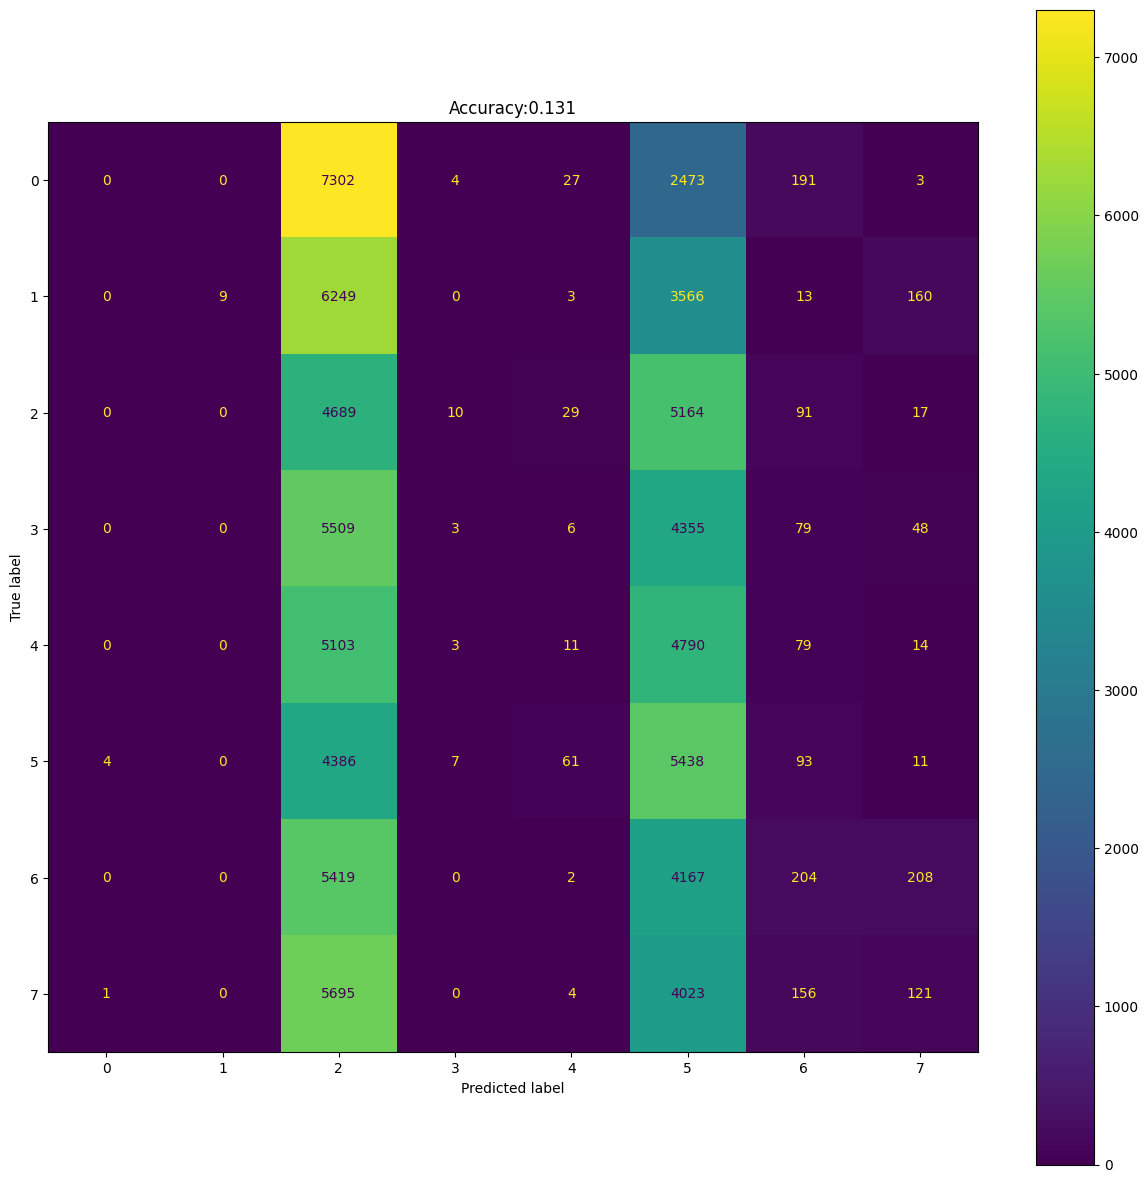

In [8]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(iii) dataset 

In [9]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [10]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [11]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 14s 5ms/step - loss: 2.6167 - accuracy: 0.1695
Epoch 2/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.0204 - accuracy: 0.2313
Epoch 3/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.8812 - accuracy: 0.2780
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.8182 - accuracy: 0.3021
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.7782 - accuracy: 0.3197
Epoch 6/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7491 - accuracy: 0.3351
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7273 - accuracy: 0.3467
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7100 - accuracy: 0.3569
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.6955 - accuracy: 0.3671
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

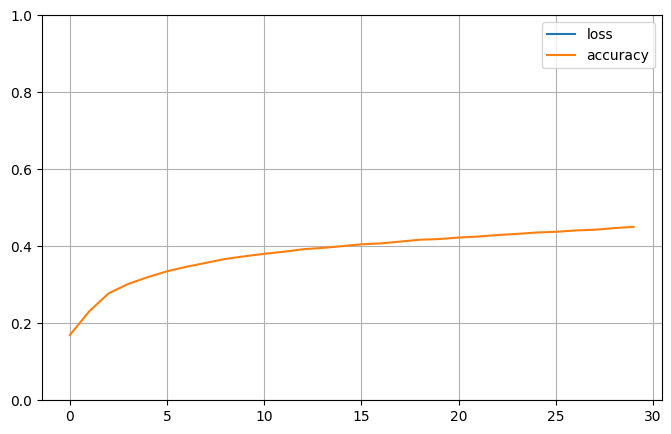

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [13]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.5482 - accuracy: 0.4542
test loss, test acc: [1.5481514930725098, 0.4542374908924103]


In [14]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[1 1 1 ... 7 6 2]
1
[[7557  314  296  264  545  503  281  240]
 [ 517 6570  249  384  520  348  977  435]
 [1284  860 2144  640 1798 1754  818  702]
 [1314 1555  859 2141 1148  923 1112  948]
 [1271  680  820  535 3698 1398  694  904]
 [1359  530 1247  436 1835 3339  640  614]
 [ 580 1076  355  455  488  434 5949  663]
 [ 607  703  553  557  921  536 1182 4941]]
              precision    recall  f1-score   support

           0       0.52      0.76      0.62     10000
           1       0.53      0.66      0.59     10000
           2       0.33      0.21      0.26     10000
           3       0.40      0.21      0.28     10000
           4       0.34      0.37      0.35     10000
           5       0.36      0.33      0.35     10000
           6       0.51      0.59      0.55     10000
           7       0.52      0.49      0.51     10000

    accuracy                           0.45     80000
   macro avg       0.44      0.45  

Test Accuracy:0.4542375


Text(0.5, 1.0, 'Accuracy:0.454')

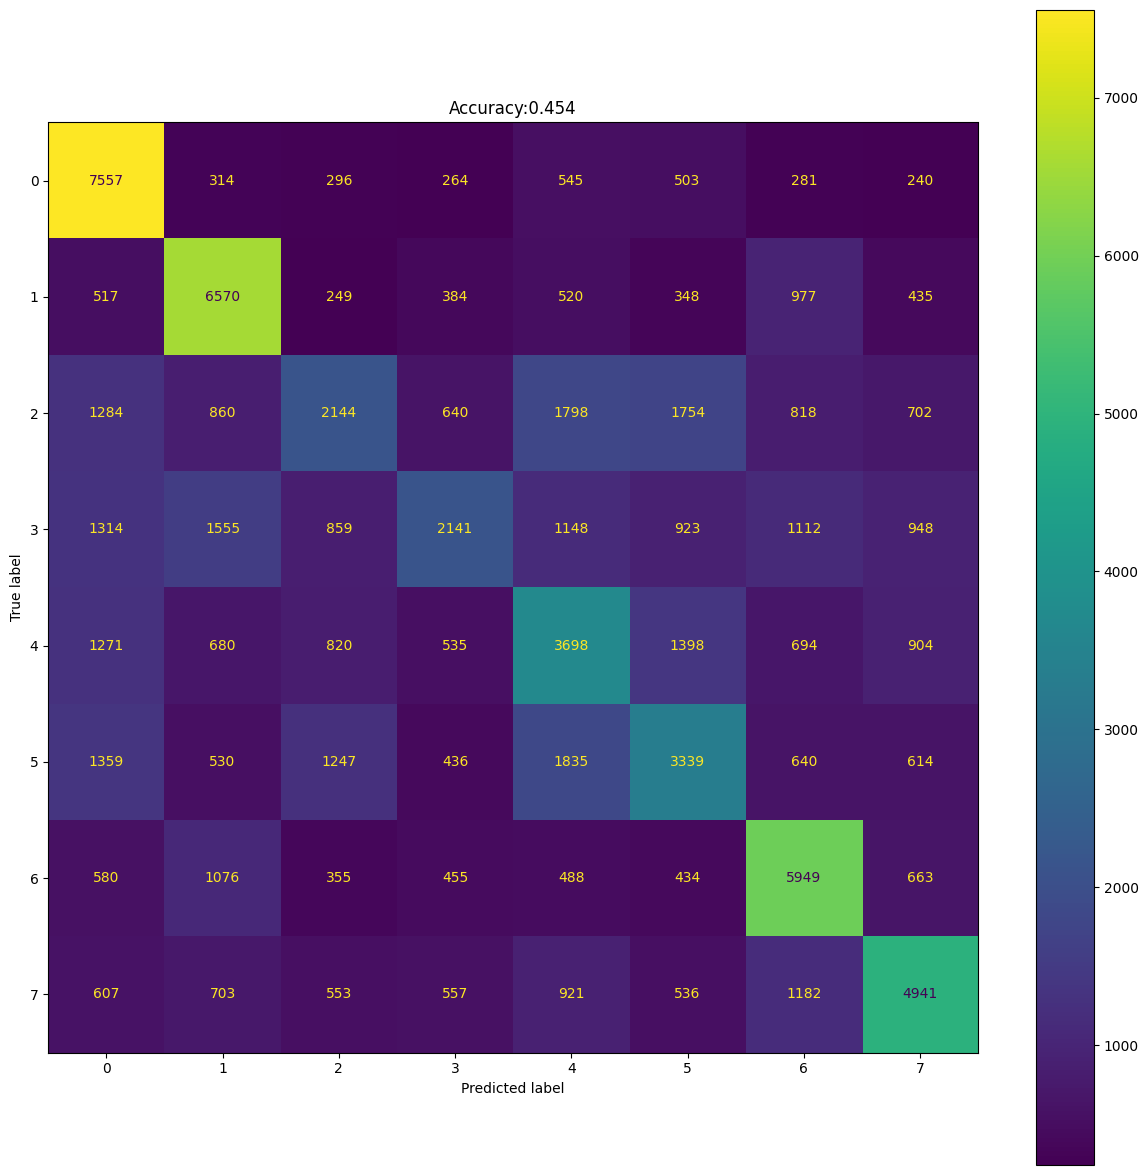

In [15]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(iii) dataset 

In [16]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [17]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 6.2078 - accuracy: 0.1187
test loss, test acc: [6.207819938659668, 0.11871249973773956]


In [18]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[7 7 7 ... 2 2 2]
7
[[  56   25 3799    0    0 4851 1266    3]
 [   2    0 5460    0    0 3224 1295   19]
 [  48    2 2866    0    0 6632  429   23]
 [  85   37 2362    0    0 5988 1490   38]
 [  35    0 5524    0    1 3910  517   13]
 [  25    0 3557    0    4 6071  332   11]
 [  95    2 2998    0    4 6318  451  132]
 [  60   10 3514    0    0 5690  674   52]]
              precision    recall  f1-score   support

           0       0.14      0.01      0.01     10000
           1       0.00      0.00      0.00     10000
           2       0.10      0.29      0.14     10000
           3       0.00      0.00      0.00     10000
           4       0.11      0.00      0.00     10000
           5       0.14      0.61      0.23     10000
           6       0.07      0.05      0.05     10000
           7       0.18      0.01      0.01     10000

    accuracy                           0.12     80000
   macro avg       0.09      0.12  

Test Accuracy:0.1187125


Text(0.5, 1.0, 'Accuracy:0.119')

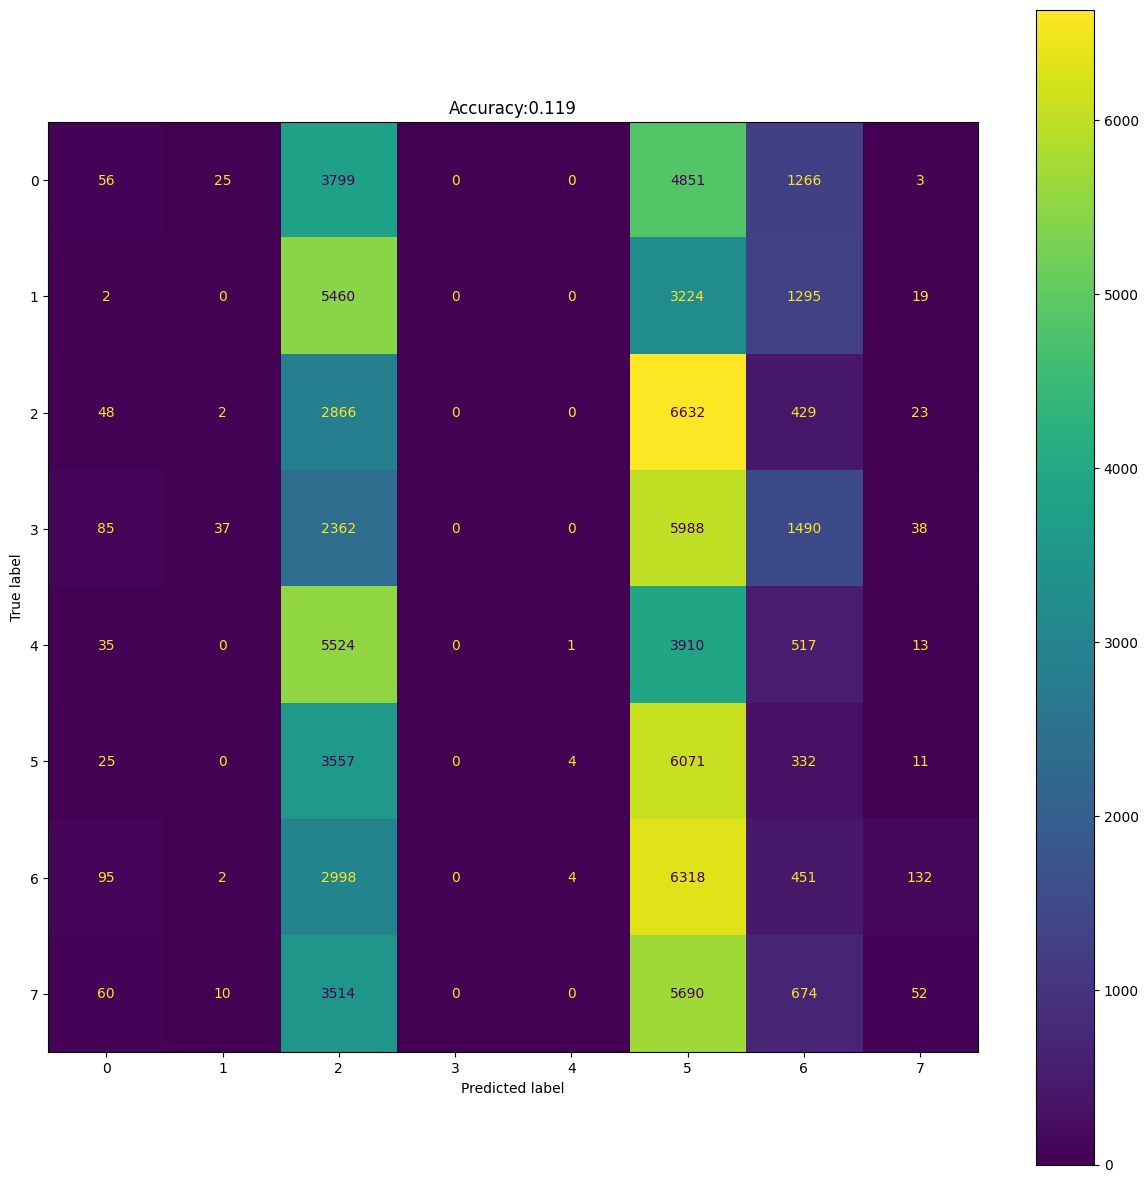

In [19]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [20]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [21]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [22]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 14s 5ms/step - loss: 2.8278 - accuracy: 0.1516
Epoch 2/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.9555 - accuracy: 0.2600
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7962 - accuracy: 0.3213
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7363 - accuracy: 0.3519
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.7024 - accuracy: 0.3677
Epoch 6/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.6790 - accuracy: 0.3801
Epoch 7/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.6609 - accuracy: 0.3885
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.6456 - accuracy: 0.3963
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.6326 - accuracy: 0.4039
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

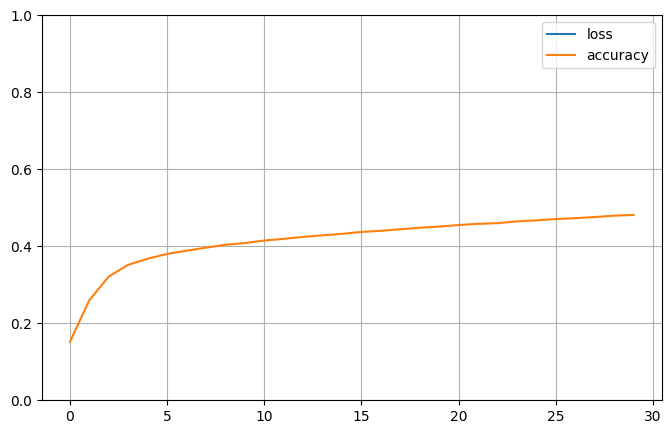

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [24]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.4727 - accuracy: 0.4837
test loss, test acc: [1.472731351852417, 0.48374998569488525]


In [25]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[1 1 1 ... 7 7 6]
1
[[6860  114  203 1093  574  779  261  116]
 [ 125 7159   62  444  380  735  651  444]
 [ 776  518 1332 1445  793 2976  898 1262]
 [1063  402  325 4959  546 1084  834  787]
 [ 837  833  396 1176 2486 2475  882  915]
 [ 667  621  665 1026  908 4713  730  670]
 [ 325  791  222 1069  453  924 5411  805]
 [ 317  630  330  886  437 1009  611 5780]]
              precision    recall  f1-score   support

           0       0.63      0.69      0.65     10000
           1       0.65      0.72      0.68     10000
           2       0.38      0.13      0.20     10000
           3       0.41      0.50      0.45     10000
           4       0.38      0.25      0.30     10000
           5       0.32      0.47      0.38     10000
           6       0.53      0.54      0.53     10000
           7       0.54      0.58      0.56     10000

    accuracy                           0.48     80000
   macro avg       0.48      0.48  

Test Accuracy:0.48375


Text(0.5, 1.0, 'Accuracy:0.484')

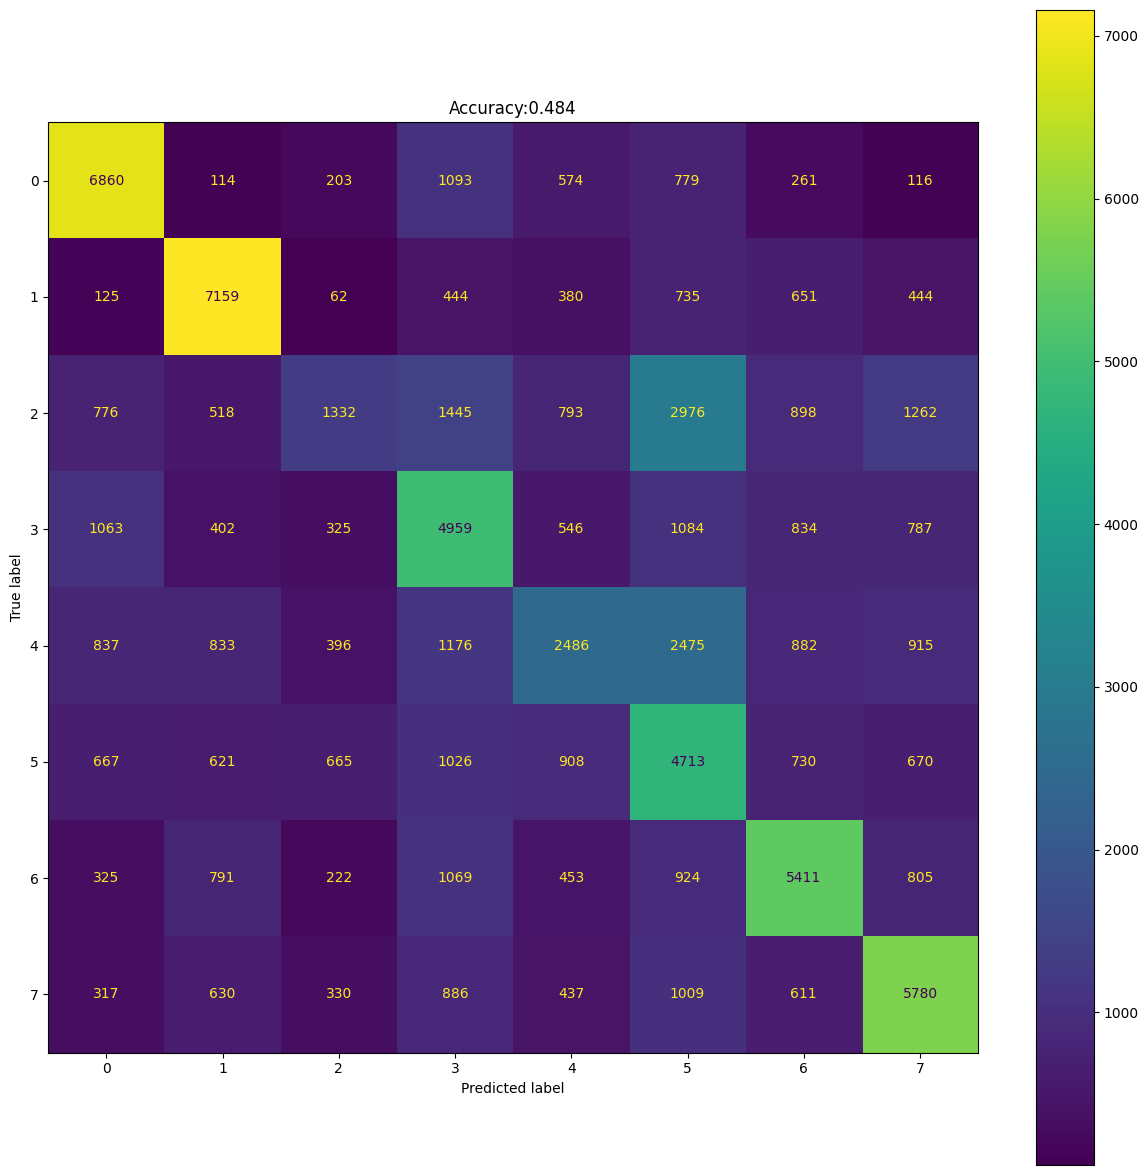

In [26]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(iii) dataset 

In [27]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [28]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 4.8692 - accuracy: 0.1302
test loss, test acc: [4.869156837463379, 0.13021250069141388]


In [29]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[2 2 6 ... 5 4 4]
2
[[ 405   62  283  169  260 7881  874   66]
 [ 205  403  654 1430  185 5193 1748  182]
 [ 399  114 1001  320  482 6521 1059  104]
 [2396   24 1862  119  246 5028  296   29]
 [ 584   71 1626  362  339 5866 1053   99]
 [ 370   63  945  237  617 7153  487  128]
 [ 269   50  526   73  270 7769  975   68]
 [1003   11  352  184 1114 6887  427   22]]
              precision    recall  f1-score   support

           0       0.07      0.04      0.05     10000
           1       0.51      0.04      0.07     10000
           2       0.14      0.10      0.12     10000
           3       0.04      0.01      0.02     10000
           4       0.10      0.03      0.05     10000
           5       0.14      0.72      0.23     10000
           6       0.14      0.10      0.12     10000
           7       0.03      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.15      0.13  

Test Accuracy:0.1302125


Text(0.5, 1.0, 'Accuracy:0.130')

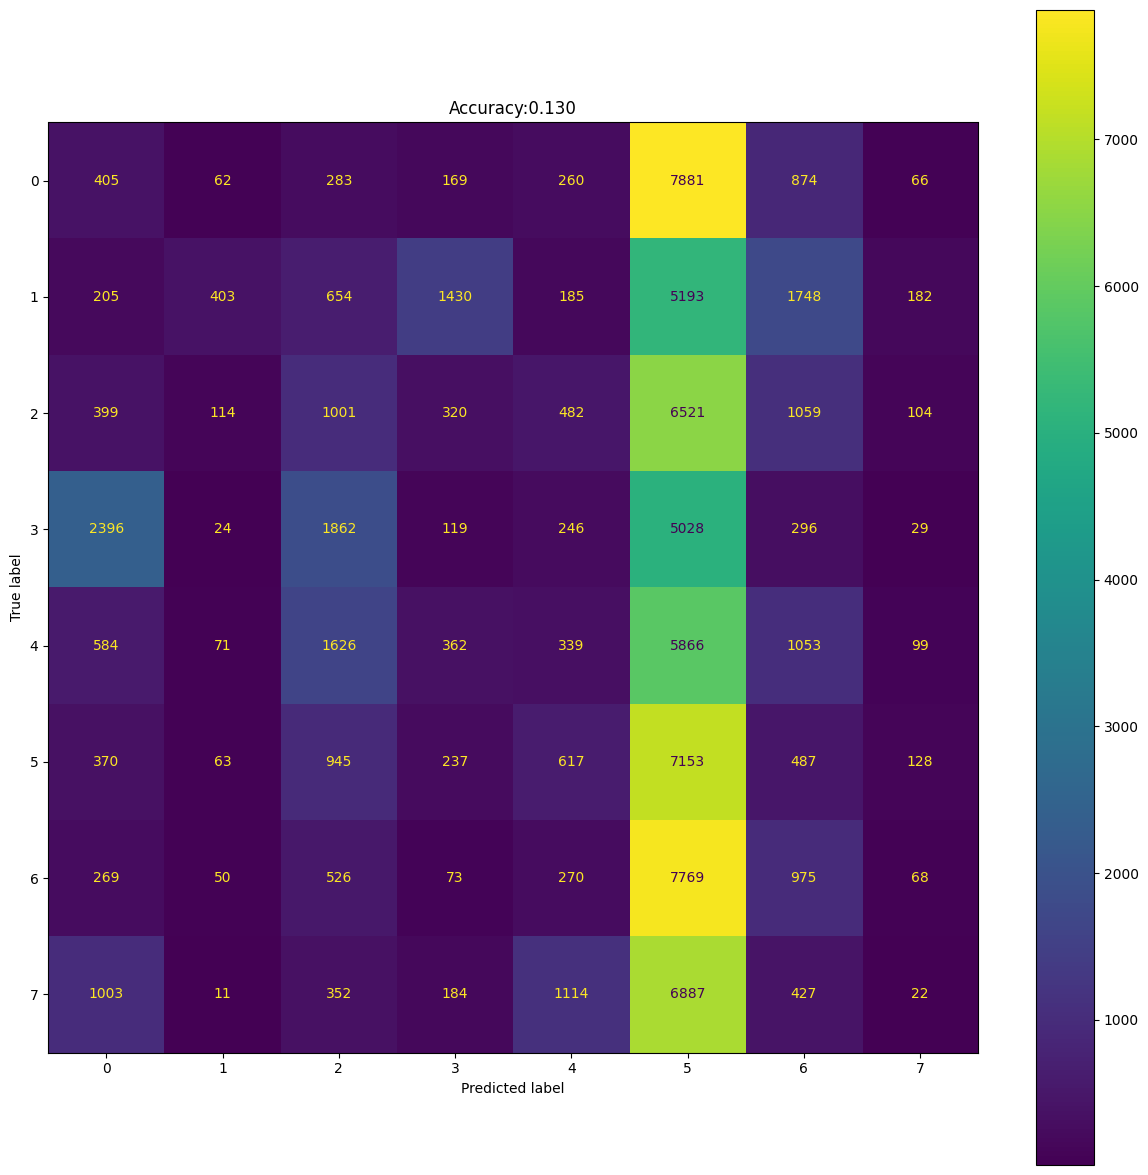

In [30]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iii) model to Nordic Device-30(iii) dataset 

In [31]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [32]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [33]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 3.0547 - accuracy: 0.1470
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.0852 - accuracy: 0.2366
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8619 - accuracy: 0.2976
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7968 - accuracy: 0.3257
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7669 - accuracy: 0.3395
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7477 - accuracy: 0.3485
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7330 - accuracy: 0.3560
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7203 - accuracy: 0.3625
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7093 - accuracy: 0.3678
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

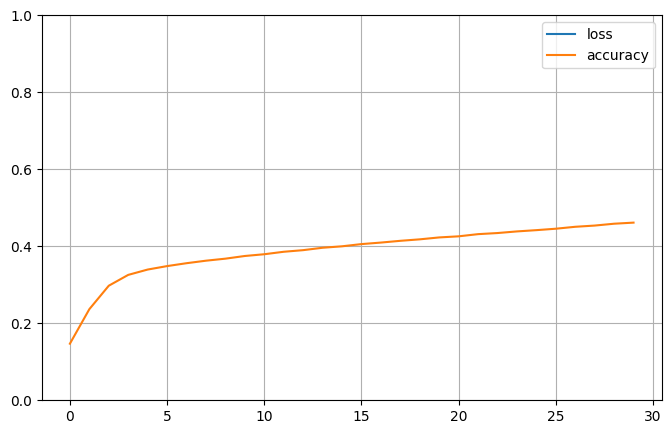

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [35]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.5513 - accuracy: 0.4604
test loss, test acc: [1.5513222217559814, 0.4603624939918518]


In [36]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[1 1 1 ... 7 7 7]
1
[[4225  999  241  795  867  917  550 1406]
 [ 377 7370  150  459  458  424  319  443]
 [ 985 1395 1274  836 1778 1706  685 1341]
 [ 393  440   78 6129 1103  644  291  922]
 [ 833  992  460 1321 3604 1325  372 1093]
 [ 858  902  518 1052 1478 2927  510 1755]
 [ 762  927  195  664  586  763 5132  971]
 [ 659  628  145  654  551  796  399 6168]]
              precision    recall  f1-score   support

           0       0.46      0.42      0.44     10000
           1       0.54      0.74      0.62     10000
           2       0.42      0.13      0.20     10000
           3       0.51      0.61      0.56     10000
           4       0.35      0.36      0.35     10000
           5       0.31      0.29      0.30     10000
           6       0.62      0.51      0.56     10000
           7       0.44      0.62      0.51     10000

    accuracy                           0.46     80000
   macro avg       0.46      0.46  

Test Accuracy:0.4603625


Text(0.5, 1.0, 'Accuracy:0.460')

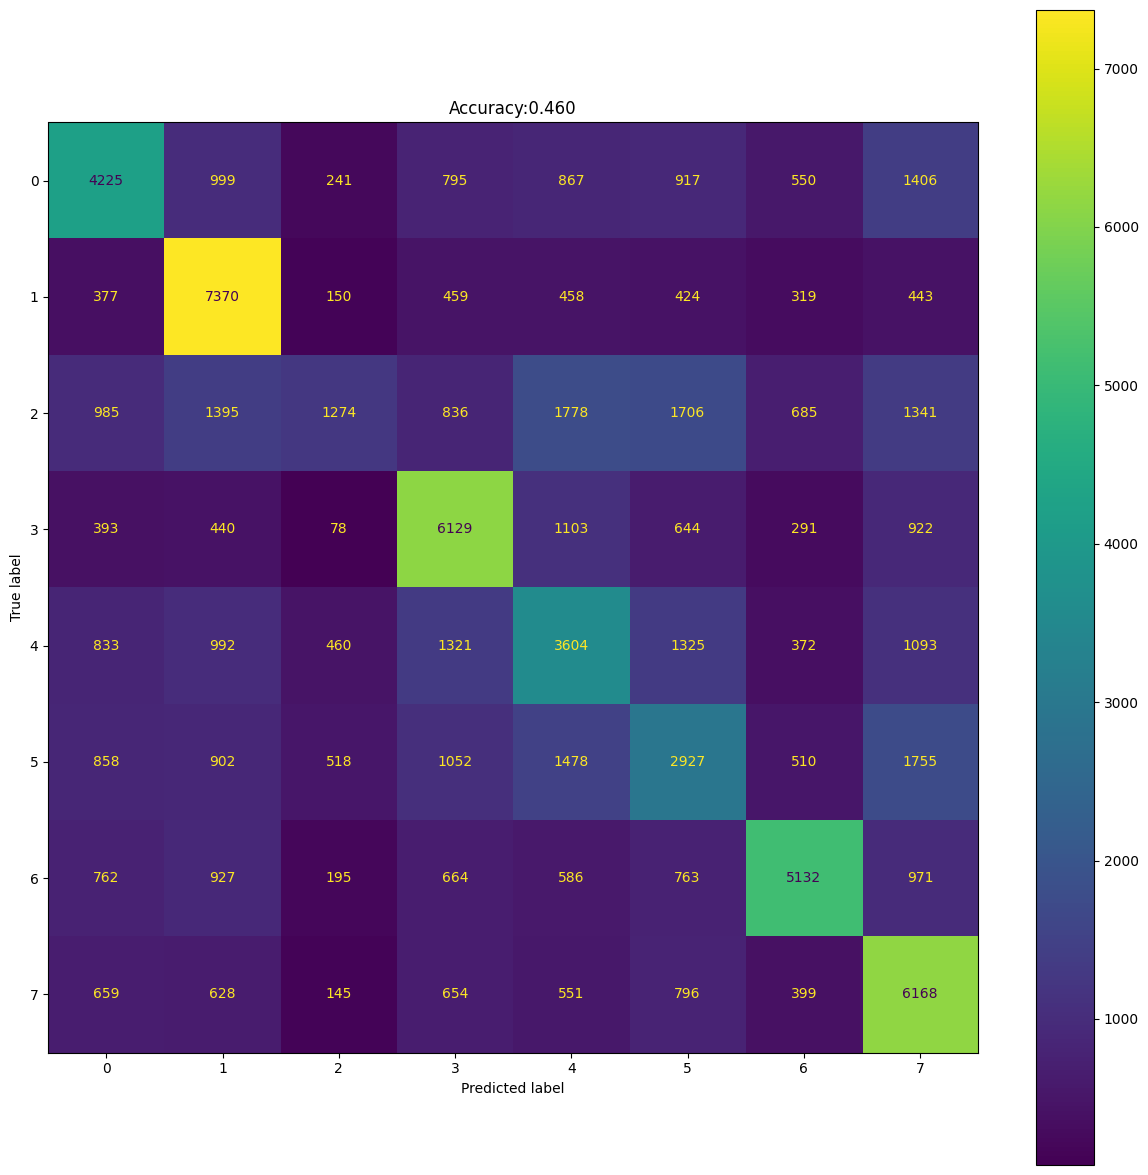

In [37]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-30(iii) dataset 

In [38]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [39]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 15s 6ms/step - loss: 4.7392 - accuracy: 0.1340
test loss, test acc: [4.739190578460693, 0.13397499918937683]


In [40]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 6 6 ... 0 5 6]
6
[[1589    3  717  122 1823 4768  345  633]
 [1601    7  471   92  604 6083  930  212]
 [1358    8  509  113  870 6126  770  246]
 [2445    0  342   61 1872 4827  277  176]
 [1486   12  452   89  716 5892 1152  201]
 [1759    4  731  194  644 5742  563  363]
 [2361   10  293   44 1213 3841 2037  201]
 [1751   14  873  210  559 6027  509   57]]
              precision    recall  f1-score   support

           0       0.11      0.16      0.13     10000
           1       0.12      0.00      0.00     10000
           2       0.12      0.05      0.07     10000
           3       0.07      0.01      0.01     10000
           4       0.09      0.07      0.08     10000
           5       0.13      0.57      0.22     10000
           6       0.31      0.20      0.25     10000
           7       0.03      0.01      0.01     10000

    accuracy                           0.13     80000
   macro avg       0.12      0.13  

Test Accuracy:0.133975


Text(0.5, 1.0, 'Accuracy:0.134')

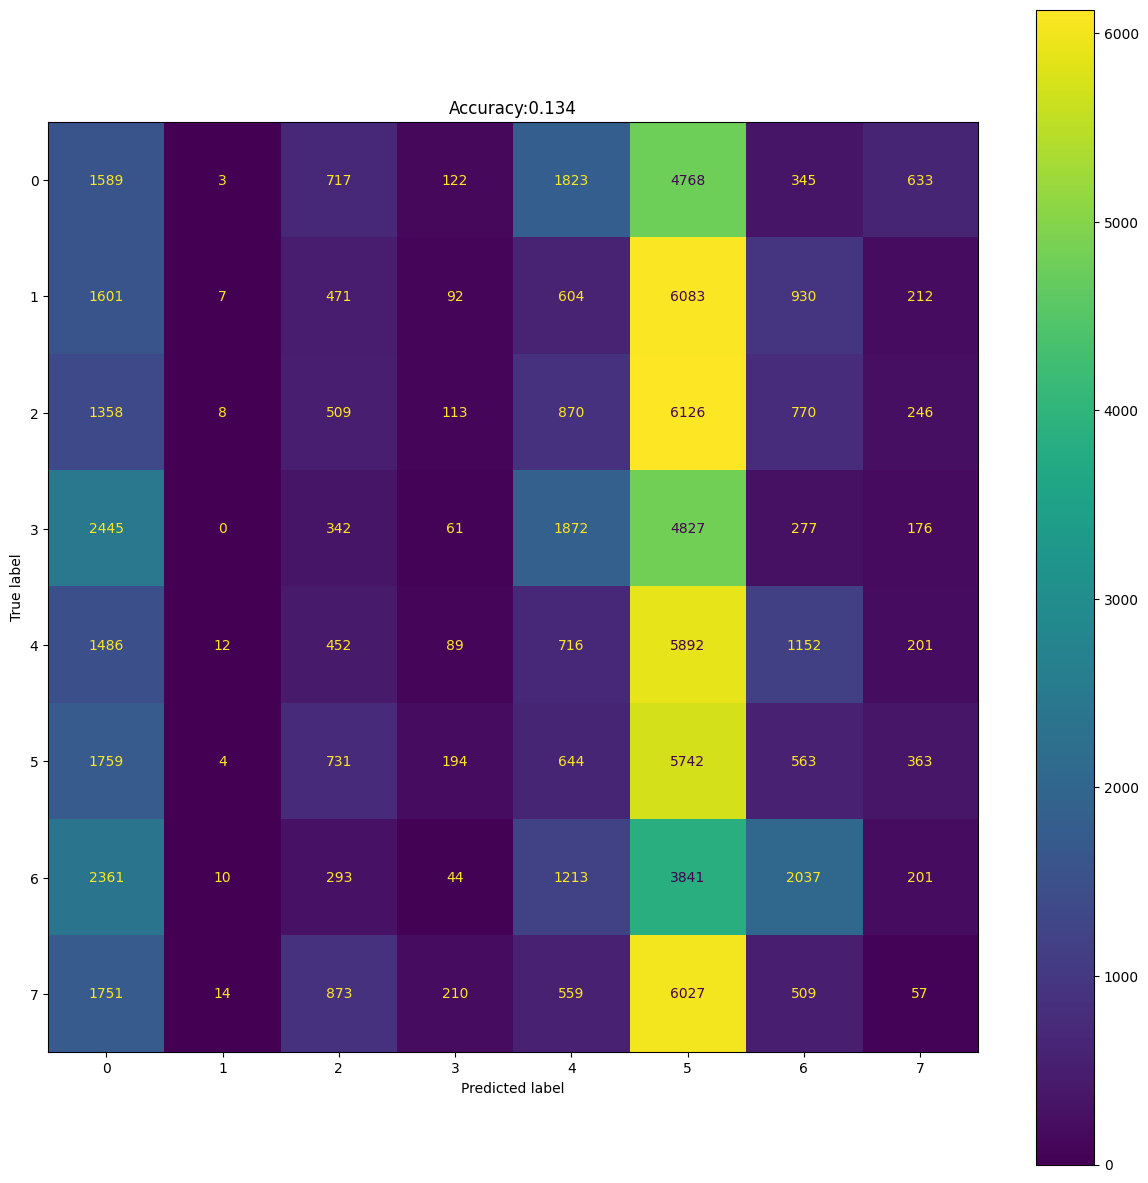

In [41]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [42]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [43]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [44]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 14s 5ms/step - loss: 3.1596 - accuracy: 0.1343
Epoch 2/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.2912 - accuracy: 0.1681
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.0140 - accuracy: 0.2172
Epoch 4/30
2500/2500 [==============================] - 16s 6ms/step - loss: 1.9237 - accuracy: 0.2601
Epoch 5/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.8830 - accuracy: 0.2891
Epoch 6/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.8591 - accuracy: 0.3047
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.8425 - accuracy: 0.3151
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.8293 - accuracy: 0.3253
Epoch 9/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.8173 - accuracy: 0.3331
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

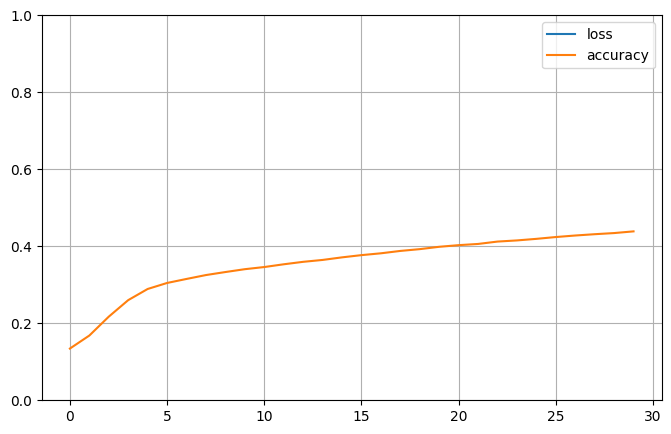

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [46]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.6485 - accuracy: 0.4363
test loss, test acc: [1.6484626531600952, 0.4363124966621399]


In [47]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[6 1 6 ... 6 7 4]
6
[[5663  277  260 1351  449  705  709  586]
 [ 725 5048  137  996  165  467 1267 1195]
 [1325  580 1506 1369 1082 1280 1162 1696]
 [1148  238  463 5169  336  517  937 1192]
 [1032  605  605 1034 2343 1156 1403 1822]
 [1452  568  729 1256  964 2459  849 1723]
 [ 603  666  150  849  198  383 6010 1141]
 [ 411  286  228  966  394  332  676 6707]]
              precision    recall  f1-score   support

           0       0.46      0.57      0.51     10000
           1       0.61      0.50      0.55     10000
           2       0.37      0.15      0.21     10000
           3       0.40      0.52      0.45     10000
           4       0.40      0.23      0.29     10000
           5       0.34      0.25      0.28     10000
           6       0.46      0.60      0.52     10000
           7       0.42      0.67      0.51     10000

    accuracy                           0.44     80000
   macro avg       0.43      0.44  

Test Accuracy:0.4363125


Text(0.5, 1.0, 'Accuracy:0.436')

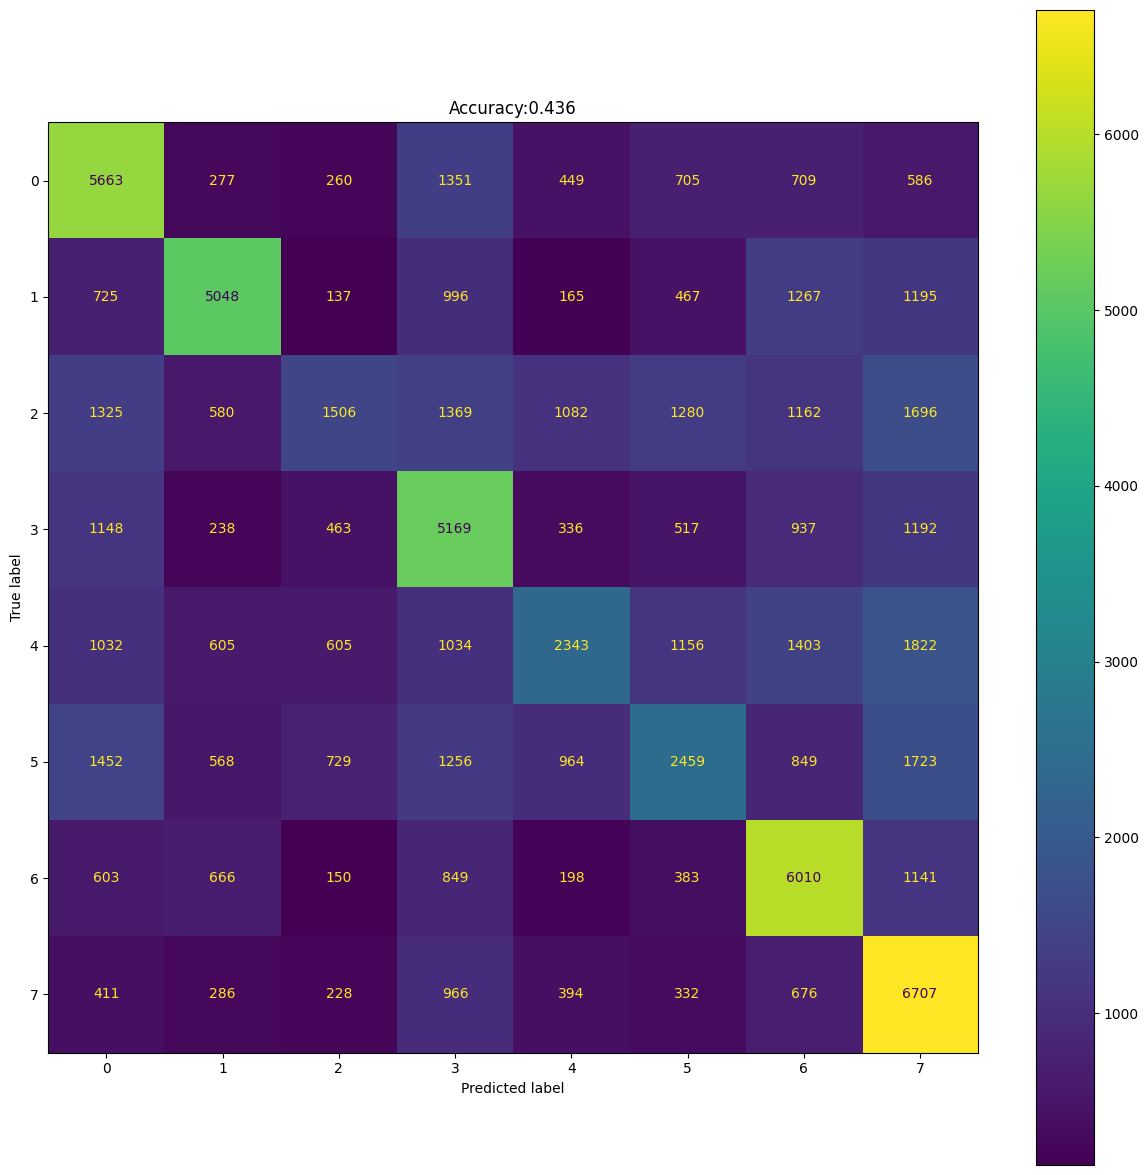

In [48]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-30(iii) dataset 

In [49]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [50]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 14s 6ms/step - loss: 5.5051 - accuracy: 0.1259
test loss, test acc: [5.50508975982666, 0.12587499618530273]


In [51]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[0 1 0 ... 2 2 0]
0
[[ 121    8 1384  171 1198 6908   70  140]
 [ 119   75 1667  797  927 6246   24  145]
 [ 373    9 1443  147  642 7308   58   20]
 [1850    0  685  110 2270 5069   13    3]
 [ 174   23 1776  431  899 6575   46   76]
 [ 230   15 1496  343  711 7133   28   44]
 [ 430   17 2438  130 1703 4946  267   69]
 [1080   10 1931   40  467 5707  743   22]]
              precision    recall  f1-score   support

           0       0.03      0.01      0.02     10000
           1       0.48      0.01      0.01     10000
           2       0.11      0.14      0.13     10000
           3       0.05      0.01      0.02     10000
           4       0.10      0.09      0.10     10000
           5       0.14      0.71      0.24     10000
           6       0.21      0.03      0.05     10000
           7       0.04      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.15      0.13  

Test Accuracy:0.125875


Text(0.5, 1.0, 'Accuracy:0.126')

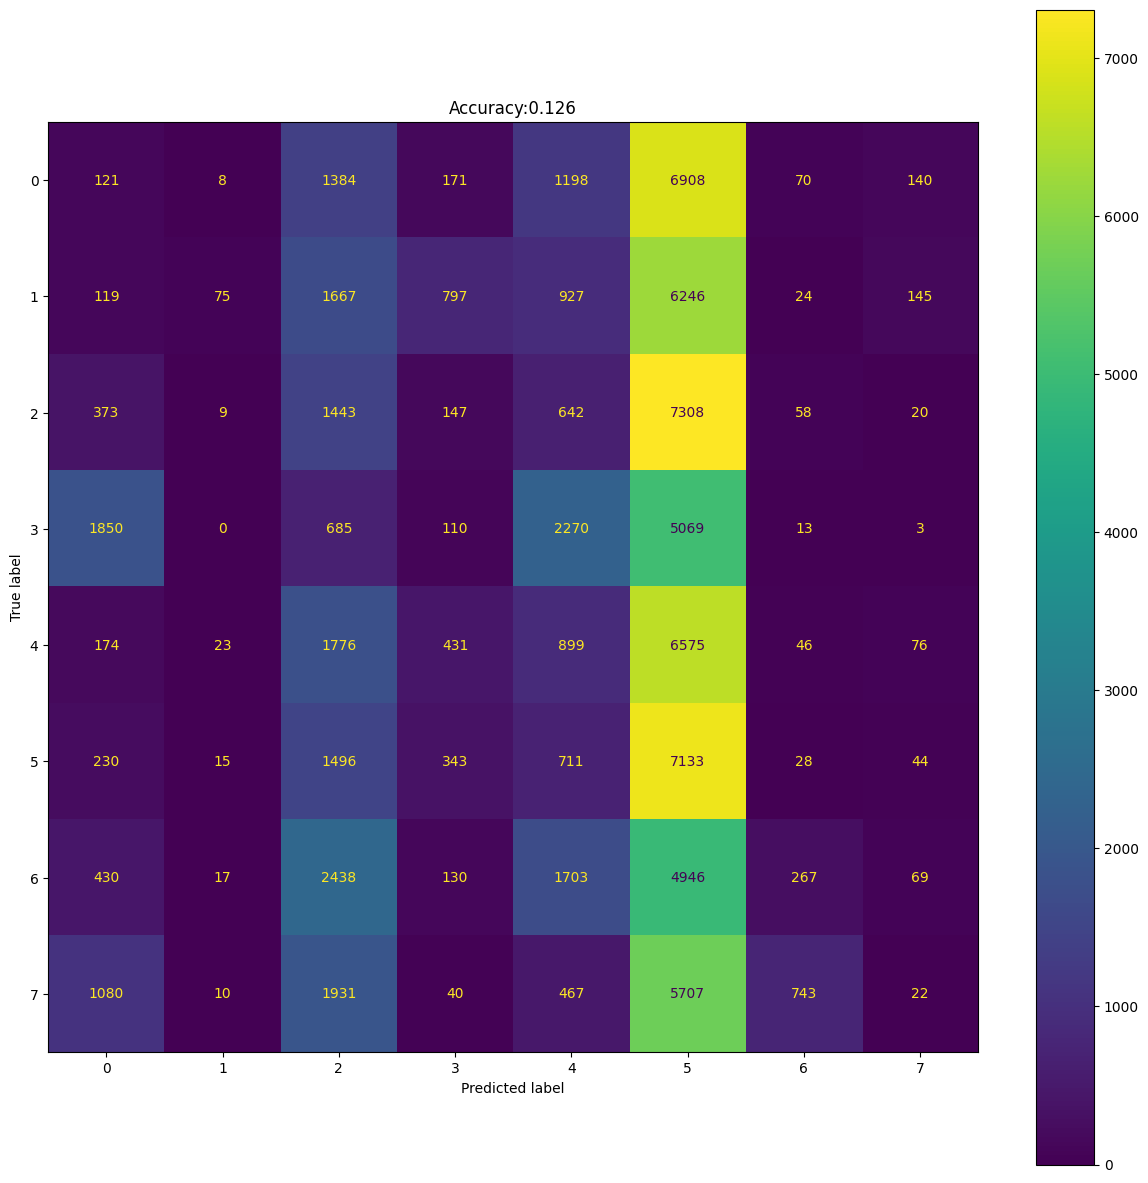

In [52]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-30(iii) dataset 

In [53]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [54]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [55]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 14s 5ms/step - loss: 3.1305 - accuracy: 0.1537
Epoch 2/30
2500/2500 [==============================] - 14s 5ms/step - loss: 2.0495 - accuracy: 0.2370
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.8657 - accuracy: 0.2945
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.8035 - accuracy: 0.3221
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7684 - accuracy: 0.3397
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.7424 - accuracy: 0.3554
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.7216 - accuracy: 0.3666
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7035 - accuracy: 0.3793
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.6873 - accuracy: 0.3887
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

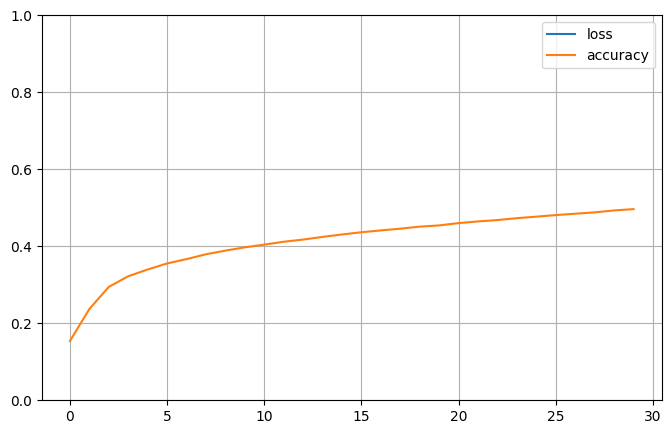

In [56]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [57]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.4809 - accuracy: 0.4954
test loss, test acc: [1.4808543920516968, 0.49537500739097595]


In [58]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[1 1 7 ... 7 7 3]
1
[[6527  346  333  728  323  493  432  818]
 [ 206 7590  342  511  286  105  516  444]
 [1177 1055 2208 1681  989  840  608 1442]
 [ 380  366  726 6887  265  423  322  631]
 [1094 1459  945 1076 2787  788  670 1181]
 [1350 1321 1113 1509 1331 1813  494 1069]
 [ 857  985  360  896  313  222 5503  864]
 [ 948  342  217  982  446  192  558 6315]]
              precision    recall  f1-score   support

           0       0.52      0.65      0.58     10000
           1       0.56      0.76      0.65     10000
           2       0.35      0.22      0.27     10000
           3       0.48      0.69      0.57     10000
           4       0.41      0.28      0.33     10000
           5       0.37      0.18      0.24     10000
           6       0.60      0.55      0.58     10000
           7       0.49      0.63      0.55     10000

    accuracy                           0.50     80000
   macro avg       0.48      0.50  

Test Accuracy:0.495375


Text(0.5, 1.0, 'Accuracy:0.495')

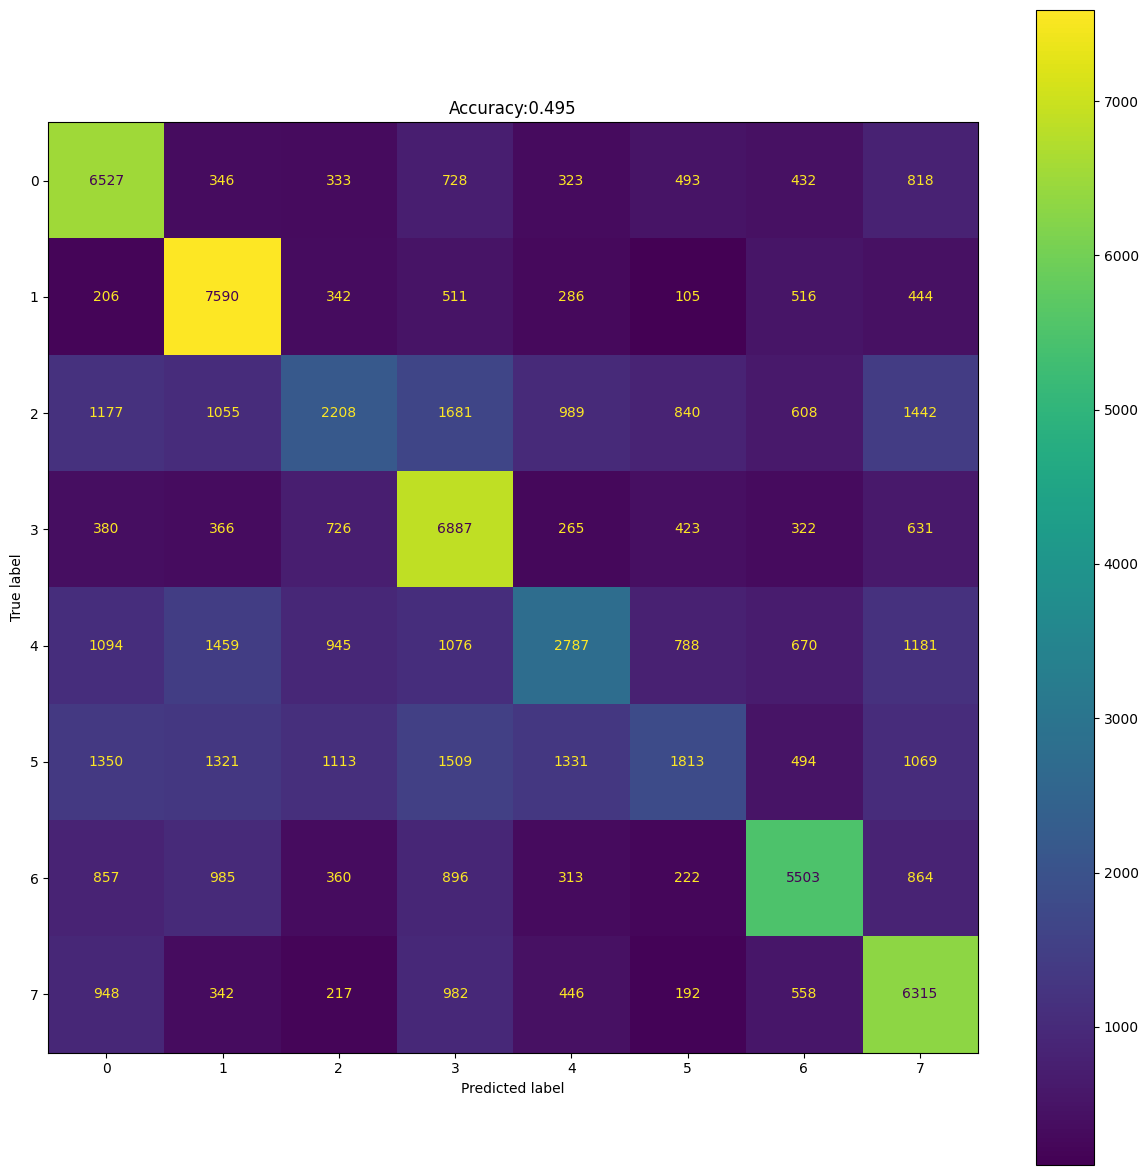

In [59]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(i) model to Nordic Device-30(iii) dataset 

In [61]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [62]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 7.3421 - accuracy: 0.1194
test loss, test acc: [7.342072010040283, 0.11940000206232071]


In [63]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[1 1 5 ... 2 6 2]
1
[[   0    2 7548    2    0   36 2410    2]
 [   0    0 9166    3    0   40  728   63]
 [   0    0 6770    5    0  889 2336    0]
 [   0    1 7232    1    0  638 2127    1]
 [   0    0 8501    8    0  688  799    4]
 [   0    0 7829    5    0  774 1391    1]
 [   0    0 7214   61    0  708 2007   10]
 [   0    0 8556    0    0  316 1128    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.11      0.68      0.19     10000
           3       0.01      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.19      0.08      0.11     10000
           6       0.16      0.20      0.18     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.06      0.12  

Test Accuracy:0.1194


Text(0.5, 1.0, 'Accuracy:0.119')

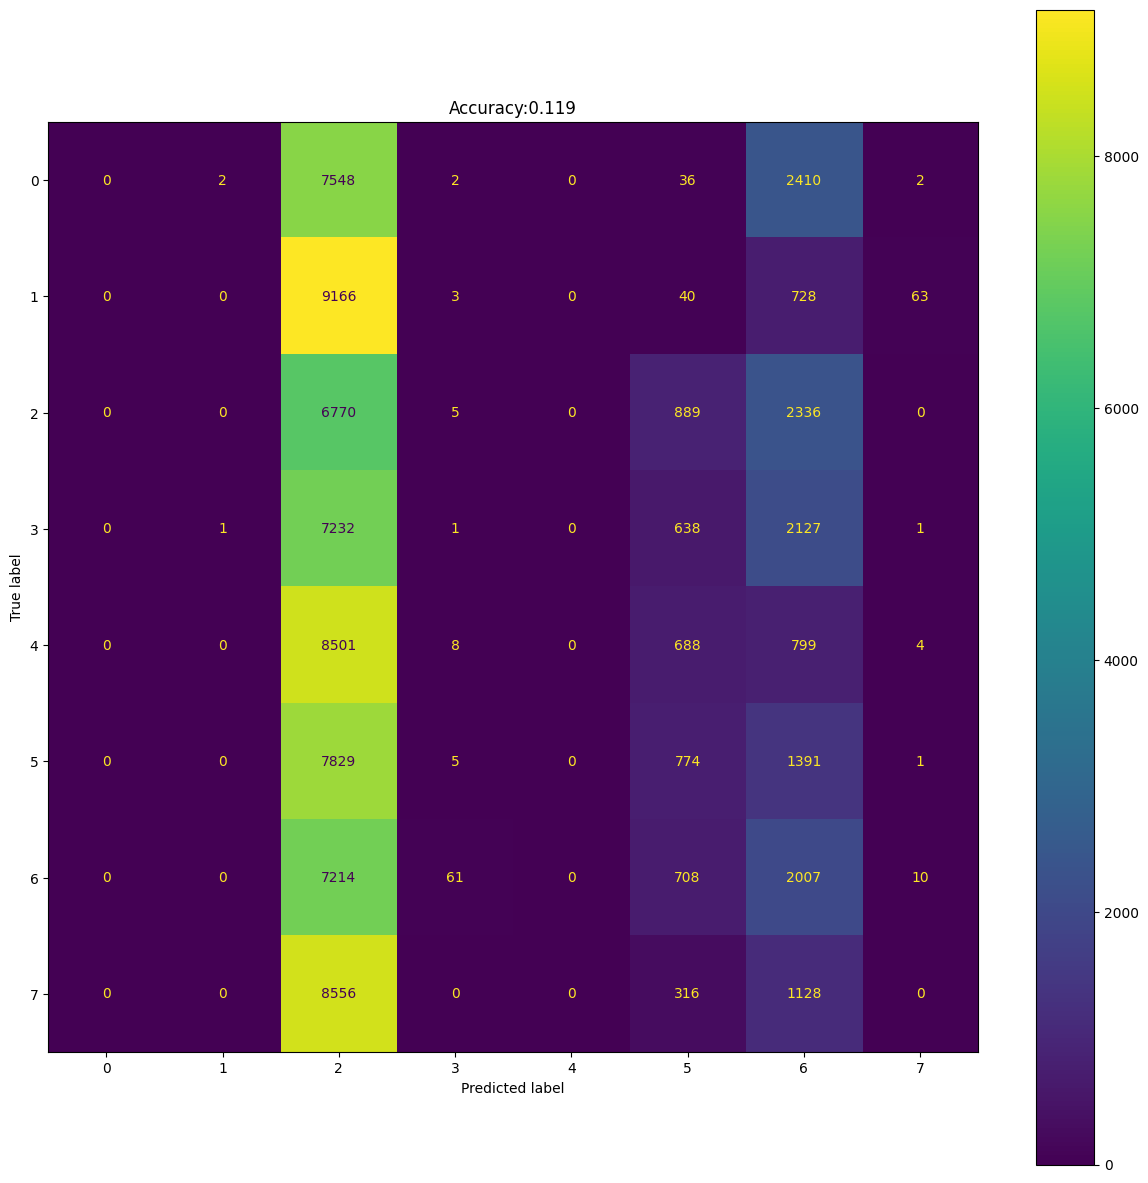

In [64]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [65]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [66]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [67]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.8107 - accuracy: 0.1463
Epoch 2/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.9636 - accuracy: 0.2664
Epoch 3/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.7788 - accuracy: 0.3339
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7070 - accuracy: 0.3608
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.6659 - accuracy: 0.3813
Epoch 6/30
2500/2500 [==============================] - 16s 6ms/step - loss: 1.6361 - accuracy: 0.3973
Epoch 7/30
2500/2500 [==============================] - 20s 8ms/step - loss: 1.6123 - accuracy: 0.4087
Epoch 8/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.5921 - accuracy: 0.4189
Epoch 9/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.5737 - accuracy: 0.4287
Epoch 10/30
2500/2500 [==============================] - 15s 6ms/step - l

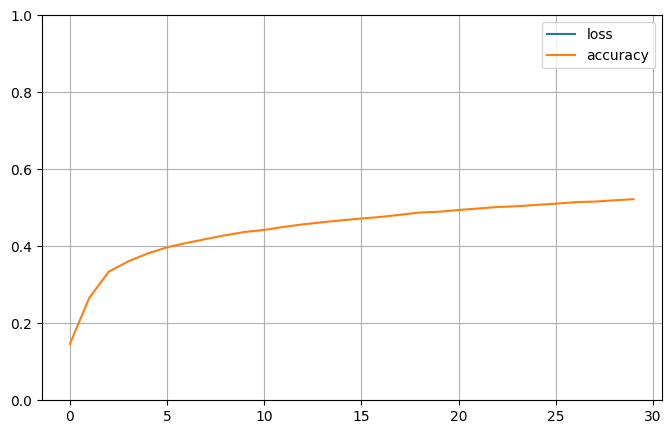

In [68]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [70]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 1.3684 - accuracy: 0.5252
test loss, test acc: [1.3684139251708984, 0.5251500010490417]


In [71]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 14s 5ms/step
[6 6 6 ... 5 2 1]
6
[[8081  453  349   89  345  216   91  376]
 [ 486 8340  251  178  223  115  235  172]
 [ 680  702 3345 1339 1475  829  915  715]
 [ 396  568 1000 5445  957  366  525  743]
 [ 556  503 1150  883 4686  680 1039  503]
 [ 895  509 1786 1244 1902 1925  521 1218]
 [ 273  771  754  754 1384  304 5492  268]
 [ 744  572  891 1138 1016  580  361 4698]]
              precision    recall  f1-score   support

           0       0.67      0.81      0.73     10000
           1       0.67      0.83      0.74     10000
           2       0.35      0.33      0.34     10000
           3       0.49      0.54      0.52     10000
           4       0.39      0.47      0.43     10000
           5       0.38      0.19      0.26     10000
           6       0.60      0.55      0.57     10000
           7       0.54      0.47      0.50     10000

    accuracy                           0.53     80000
   macro avg       0.51      0.53  

Test Accuracy:0.52515


Text(0.5, 1.0, 'Accuracy:0.525')

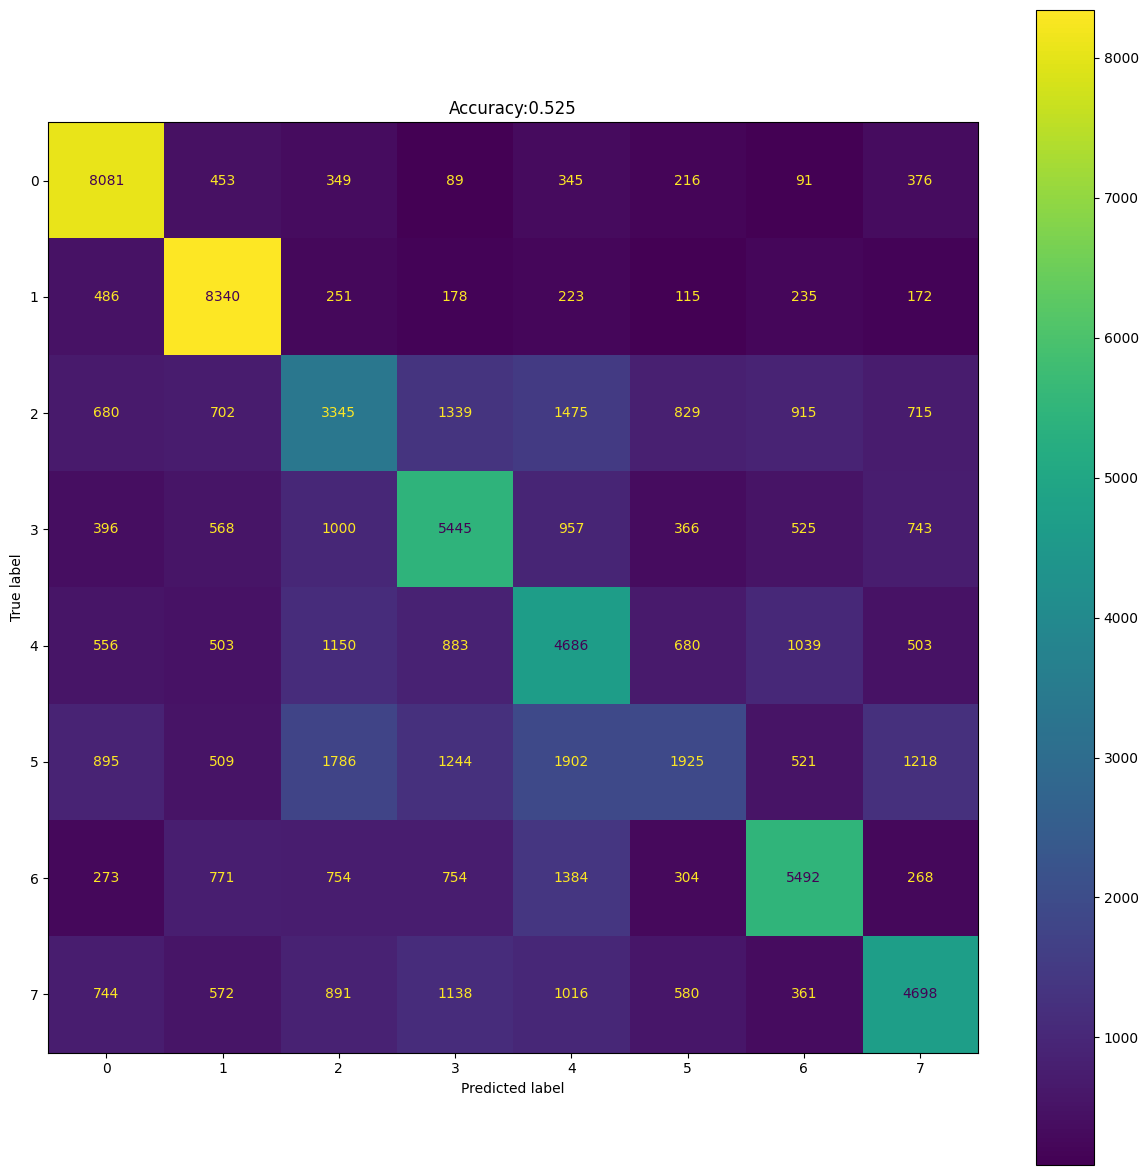

In [72]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-30(iii) dataset 

In [73]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [74]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 22s 9ms/step - loss: 8.0495 - accuracy: 0.1503
test loss, test acc: [8.049521446228027, 0.15029999613761902]


In [75]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[1 1 1 ... 5 2 2]
1
[[  57    3 3762   13    0 3530 2635    0]
 [   0   45 2607   20    0 5494 1702  132]
 [  15    1 2825    1    0 6145 1007    6]
 [  17    0 2293    0    0 7064  624    2]
 [  18    2 2539    3    0 6525  909    4]
 [  23    0 2407    0    0 7106  461    3]
 [   7   11 2746   36    0 5154 1989   57]
 [  27    1 4618    3    0 4158 1191    2]]
              precision    recall  f1-score   support

           0       0.35      0.01      0.01     10000
           1       0.71      0.00      0.01     10000
           2       0.12      0.28      0.17     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.16      0.71      0.26     10000
           6       0.19      0.20      0.19     10000
           7       0.01      0.00      0.00     10000

    accuracy                           0.15     80000
   macro avg       0.19      0.15  

Test Accuracy:0.1503


Text(0.5, 1.0, 'Accuracy:0.150')

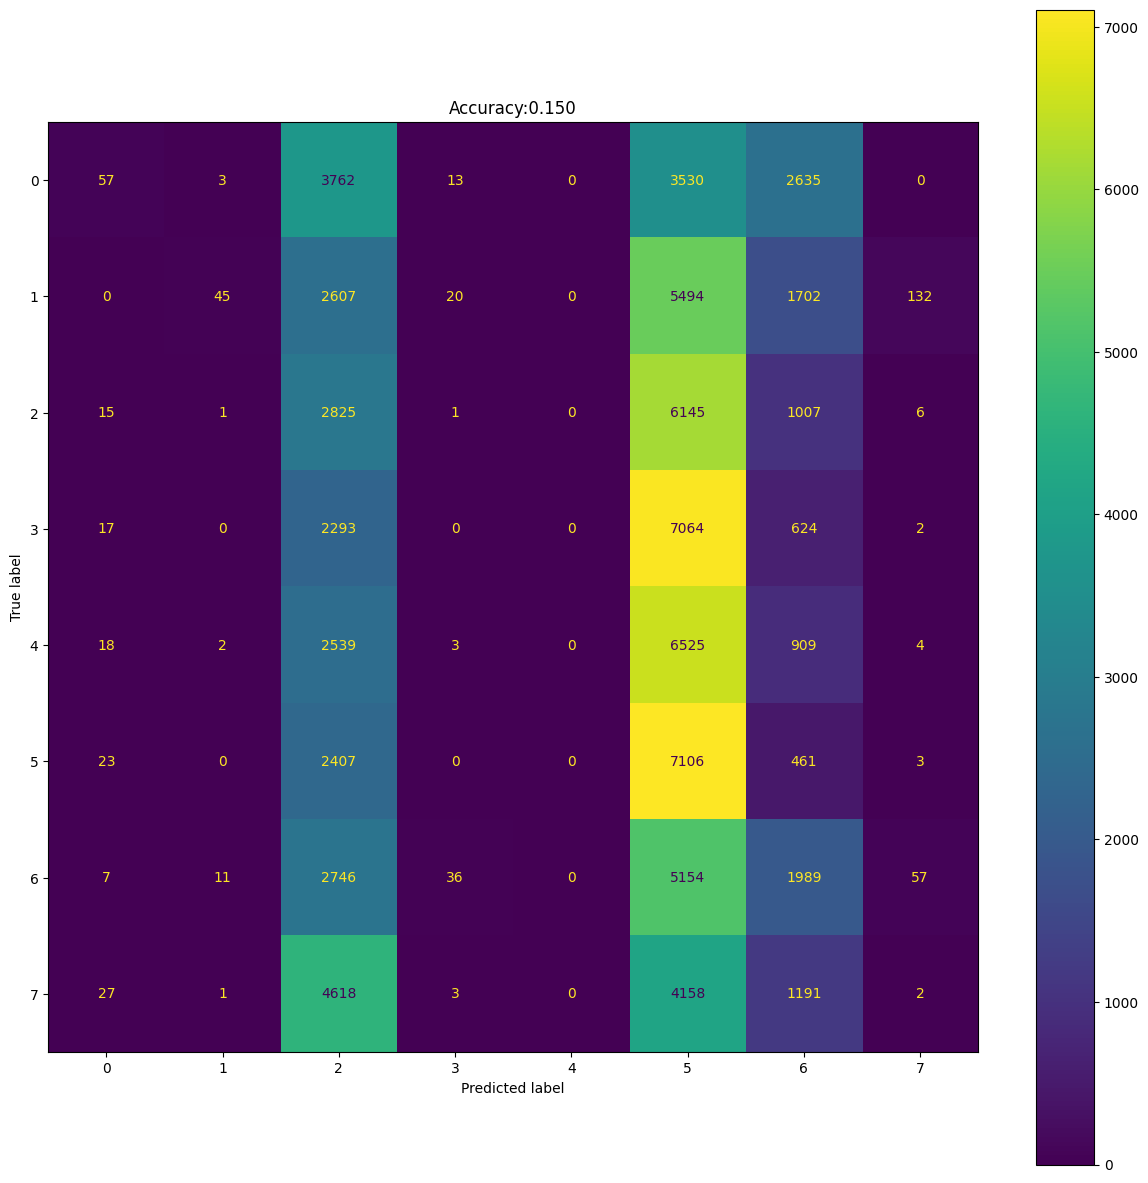

In [76]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [77]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [78]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [79]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 15s 6ms/step - loss: 2.8478 - accuracy: 0.1755
Epoch 2/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.0799 - accuracy: 0.2246
Epoch 3/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.9399 - accuracy: 0.2530
Epoch 4/30
2500/2500 [==============================] - 16s 6ms/step - loss: 1.8764 - accuracy: 0.2797
Epoch 5/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.8361 - accuracy: 0.3019
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8063 - accuracy: 0.3199
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7803 - accuracy: 0.3383
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.7579 - accuracy: 0.3533
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7389 - accuracy: 0.3647
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

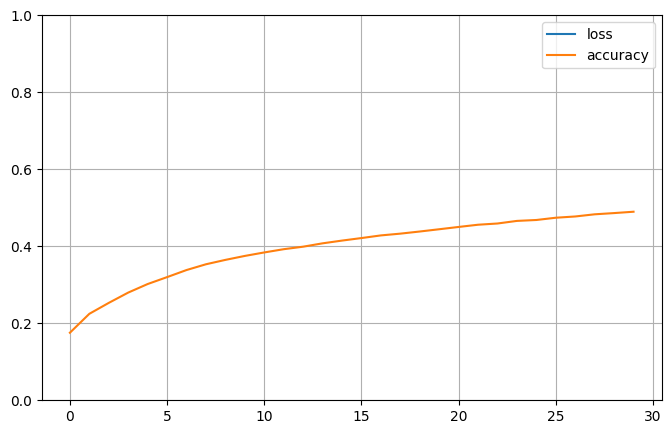

In [80]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [81]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.5025 - accuracy: 0.4893
test loss, test acc: [1.5024672746658325, 0.4892500042915344]


In [82]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[3 3 3 ... 5 7 1]
3
[[7227  432  300   56  130  849  547  459]
 [ 903 6941  187  444   54  620  649  202]
 [1351  743 1668 1024  465 2824 1074  851]
 [ 518  593  458 5453  147 1554  712  565]
 [1623  530  789  419 1847 2858 1251  683]
 [1051  456  806  936  558 4966  624  603]
 [1187  802  216  454  135 1005 5799  402]
 [1325  474  349  519  151 1283  660 5239]]
              precision    recall  f1-score   support

           0       0.48      0.72      0.57     10000
           1       0.63      0.69      0.66     10000
           2       0.35      0.17      0.23     10000
           3       0.59      0.55      0.56     10000
           4       0.53      0.18      0.27     10000
           5       0.31      0.50      0.38     10000
           6       0.51      0.58      0.54     10000
           7       0.58      0.52      0.55     10000

    accuracy                           0.49     80000
   macro avg       0.50      0.49  

Test Accuracy:0.48925


Text(0.5, 1.0, 'Accuracy:0.489')

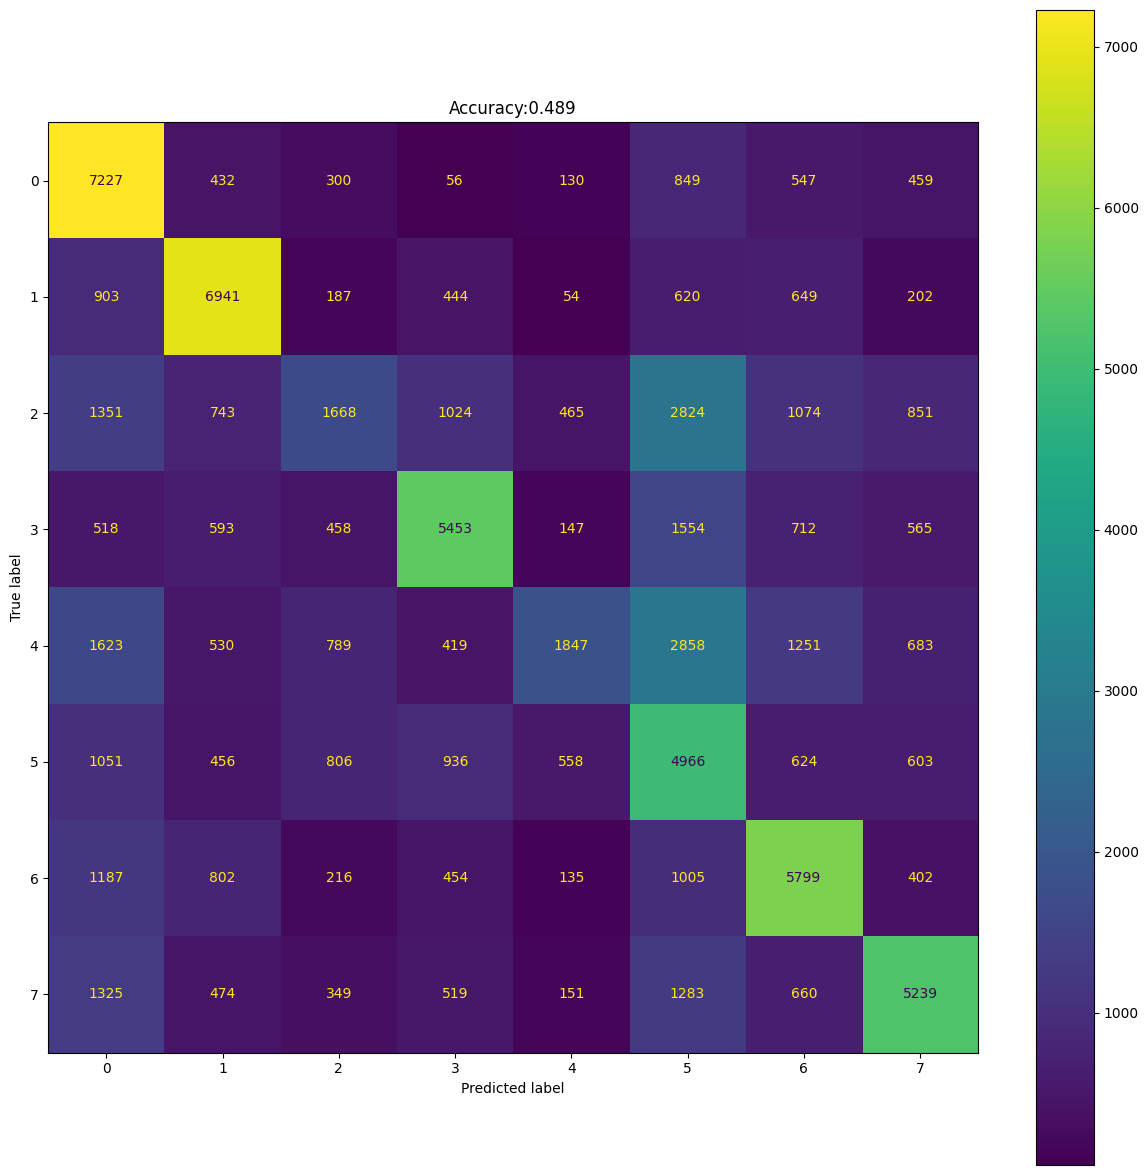

In [83]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-30(iii) dataset 

In [84]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [85]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 14s 5ms/step - loss: 2.5760 - accuracy: 0.5894
test loss, test acc: [2.576007843017578, 0.5894250273704529]


In [86]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 2 6 ... 7 7 7]
6
[[4535    0   89    2    2 5368    4    0]
 [   0 9954    9    0    0   33    4    0]
 [ 790    0 1091   54    0 8020   45    0]
 [  17    0   56 9617    6  299    4    1]
 [4574    0  380    2    0 5040    4    0]
 [1867    0  781   27    0 7316    9    0]
 [  37    0 1448    1    0   98 8416    0]
 [  49    0   16    4    0 3687   19 6225]]
              precision    recall  f1-score   support

           0       0.38      0.45      0.41     10000
           1       1.00      1.00      1.00     10000
           2       0.28      0.11      0.16     10000
           3       0.99      0.96      0.98     10000
           4       0.00      0.00      0.00     10000
           5       0.25      0.73      0.37     10000
           6       0.99      0.84      0.91     10000
           7       1.00      0.62      0.77     10000

    accuracy                           0.59     80000
   macro avg       0.61      0.59  

Test Accuracy:0.589425


Text(0.5, 1.0, 'Accuracy:0.589')

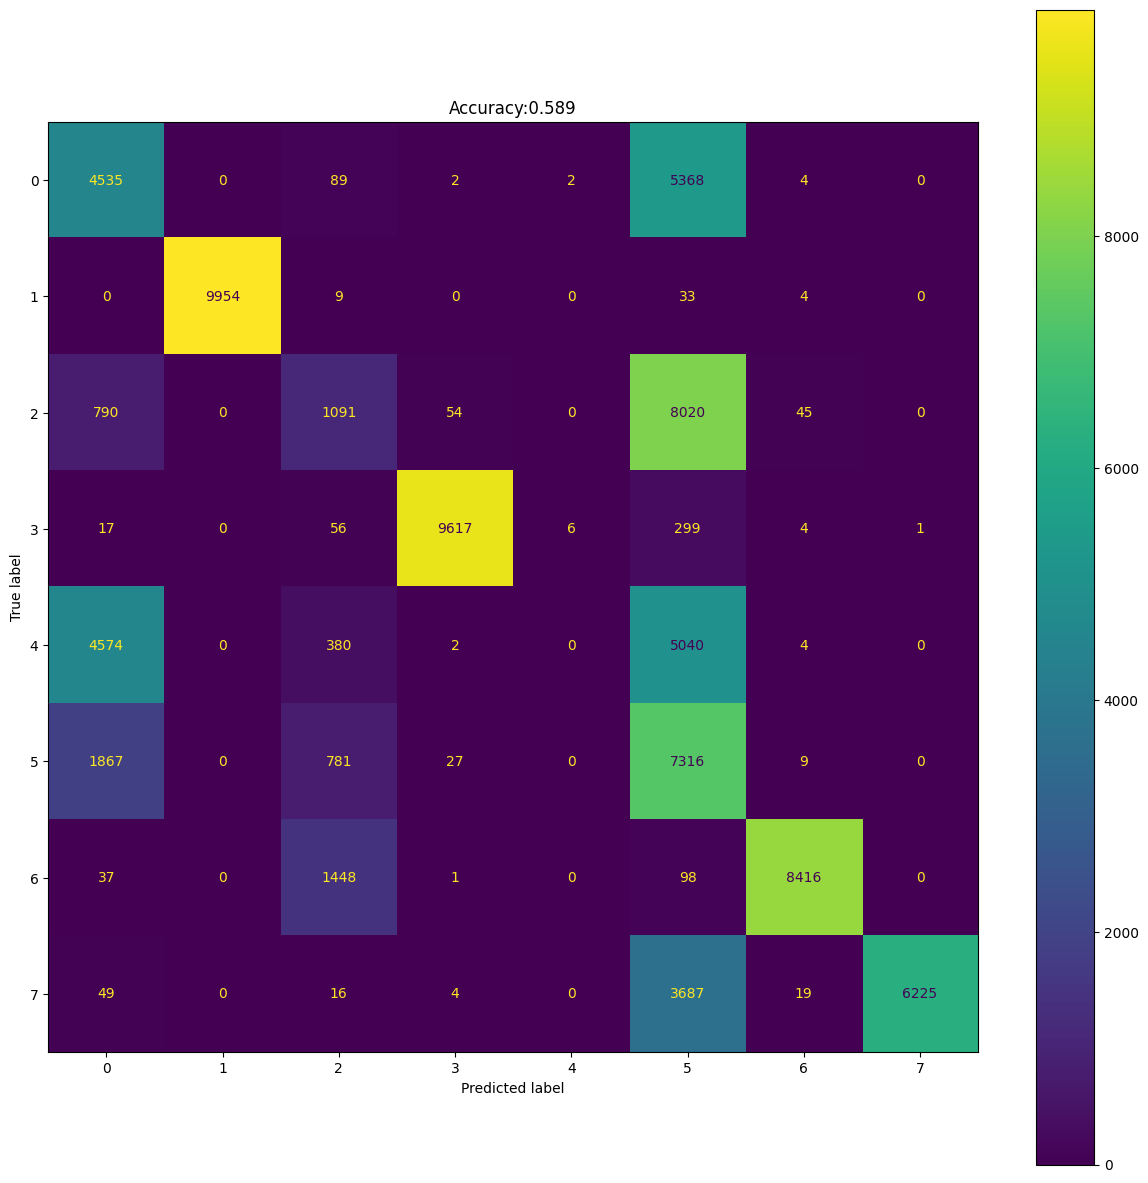

In [87]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [88]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [89]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [90]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.0050 - accuracy: 0.6598
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6857 - accuracy: 0.7072
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6492 - accuracy: 0.7244
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6389 - accuracy: 0.7293
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6328 - accuracy: 0.7332
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6281 - accuracy: 0.7360
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6238 - accuracy: 0.7390
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6201 - accuracy: 0.7397
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6169 - accuracy: 0.7421
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

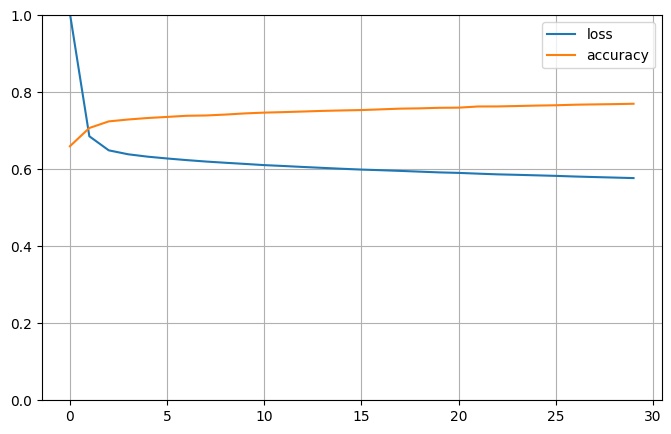

In [91]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [92]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.5768 - accuracy: 0.7719
test loss, test acc: [0.5767529010772705, 0.771887481212616]


In [93]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 6 6 ... 7 7 7]
6
[[7162    0  668    1 1644  438    5   82]
 [   4 9958   34    0    0    1    3    0]
 [ 429    1 6934   52  835 1593   76   80]
 [  12    0  206 9727   20   14    4   17]
 [2025    0 1775    4 4793 1371    5   27]
 [ 673    1 3970   25 1675 3587   15   54]
 [  33    0   61    0   11   55 9837    3]
 [  74    0  154    5    4    9    1 9753]]
              precision    recall  f1-score   support

           0       0.69      0.72      0.70     10000
           1       1.00      1.00      1.00     10000
           2       0.50      0.69      0.58     10000
           3       0.99      0.97      0.98     10000
           4       0.53      0.48      0.51     10000
           5       0.51      0.36      0.42     10000
           6       0.99      0.98      0.99     10000
           7       0.97      0.98      0.97     10000

    accuracy                           0.77     80000
   macro avg       0.77      0.77  

Test Accuracy:0.7718875


Text(0.5, 1.0, 'Accuracy:0.772')

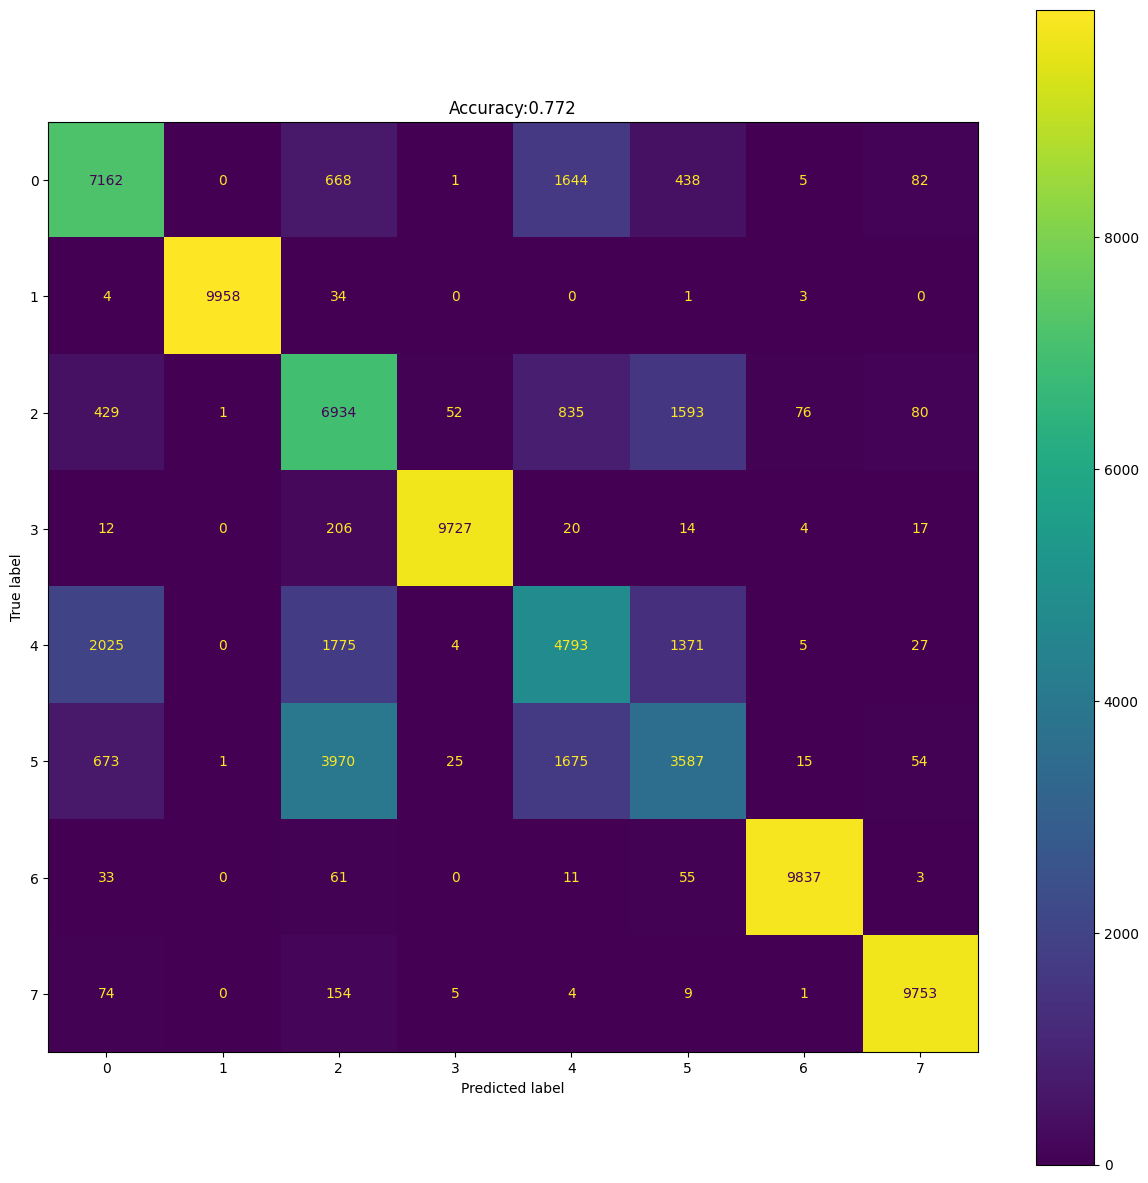

In [94]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-30(iii) dataset 

In [95]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [96]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 2.4622 - accuracy: 0.5556
test loss, test acc: [2.462191343307495, 0.5556374788284302]


In [97]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[4 6 4 ... 5 7 7]
4
[[6972    6  156    6    4 2841    4   11]
 [   4 9945   17    1    0   31    1    1]
 [4033    7 1591  185    0 4151   32    1]
 [  89    2   29 9798    6   72    4    0]
 [4749    1  310   57    0 4857   23    3]
 [4635    7  567  145    0 4627   16    3]
 [ 820   17 3870  199    0  541 4553    0]
 [ 672    0   56   24    0 2282    1 6965]]
              precision    recall  f1-score   support

           0       0.32      0.70      0.44     10000
           1       1.00      0.99      1.00     10000
           2       0.24      0.16      0.19     10000
           3       0.94      0.98      0.96     10000
           4       0.00      0.00      0.00     10000
           5       0.24      0.46      0.31     10000
           6       0.98      0.46      0.62     10000
           7       1.00      0.70      0.82     10000

    accuracy                           0.56     80000
   macro avg       0.59      0.56  

Test Accuracy:0.5556375


Text(0.5, 1.0, 'Accuracy:0.556')

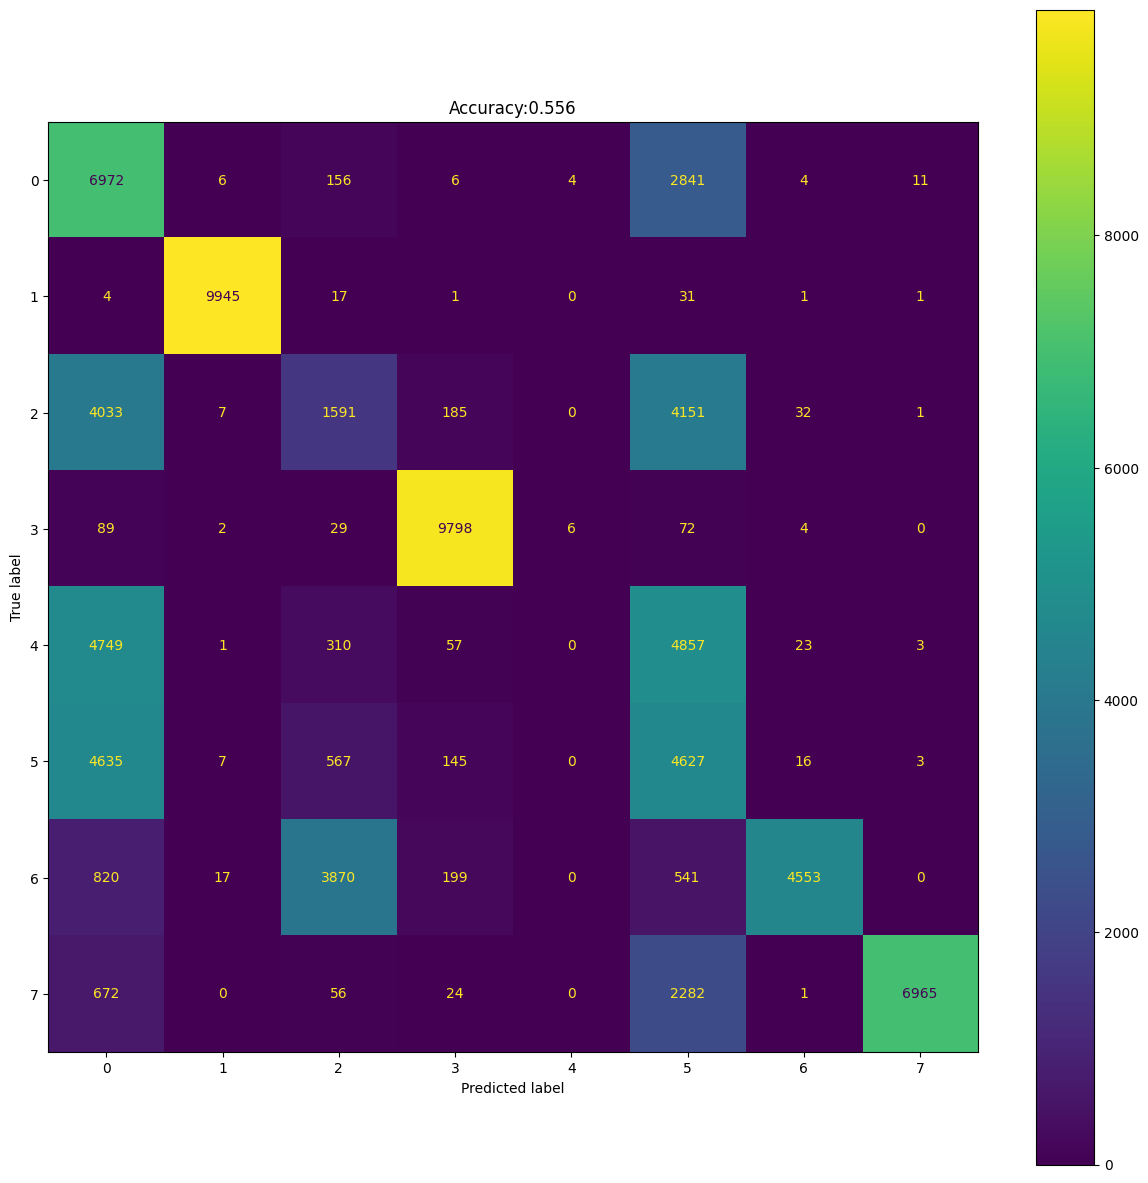

In [98]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')



## Cross-model Validation by applying Transfer Learning of other Device's Model

In [99]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [100]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [101]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.0780 - accuracy: 0.6366
Epoch 2/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.8725 - accuracy: 0.6647
Epoch 3/30
2500/2500 [==============================] - 14s 6ms/step - loss: 0.7925 - accuracy: 0.6816
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.7525 - accuracy: 0.6950
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.7302 - accuracy: 0.7035
Epoch 6/30
2500/2500 [==============================] - 27s 11ms/step - loss: 0.7160 - accuracy: 0.7108
Epoch 7/30
2500/2500 [==============================] - 25s 10ms/step - loss: 0.7064 - accuracy: 0.7142
Epoch 8/30
2500/2500 [==============================] - 14s 5ms/step - loss: 0.6991 - accuracy: 0.7200
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6936 - accuracy: 0.7228
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step -

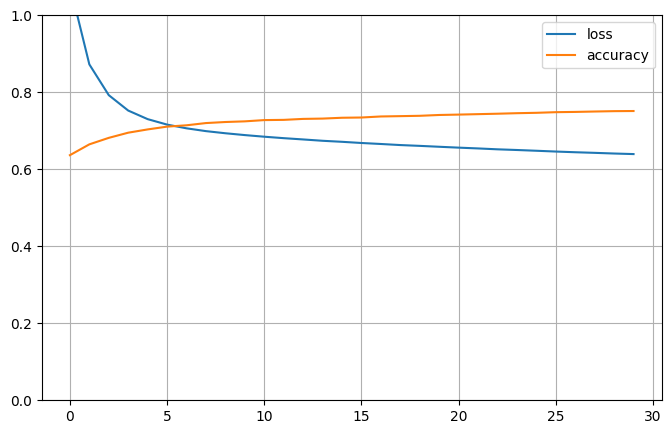

In [102]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [103]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 0.6380 - accuracy: 0.7521
test loss, test acc: [0.6379984021186829, 0.7521250247955322]


In [104]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 6 6 ... 7 7 7]
6
[[7166    0 1078    2 1110  511   65   68]
 [   4 9938   37    1    6    0   13    1]
 [ 924    2 6309   35 1100 1194  410   26]
 [  14    0  107 9764   17   38   54    6]
 [1888    0 1941   14 4702 1148  214   93]
 [1348    1 3431   19 1942 3038  161   60]
 [  30    0  312   19  118   52 9467    2]
 [  56    0   37    0   80   34    7 9786]]
              precision    recall  f1-score   support

           0       0.63      0.72      0.67     10000
           1       1.00      0.99      1.00     10000
           2       0.48      0.63      0.54     10000
           3       0.99      0.98      0.98     10000
           4       0.52      0.47      0.49     10000
           5       0.51      0.30      0.38     10000
           6       0.91      0.95      0.93     10000
           7       0.97      0.98      0.98     10000

    accuracy                           0.75     80000
   macro avg       0.75      0.75  

Test Accuracy:0.752125


Text(0.5, 1.0, 'Accuracy:0.752')

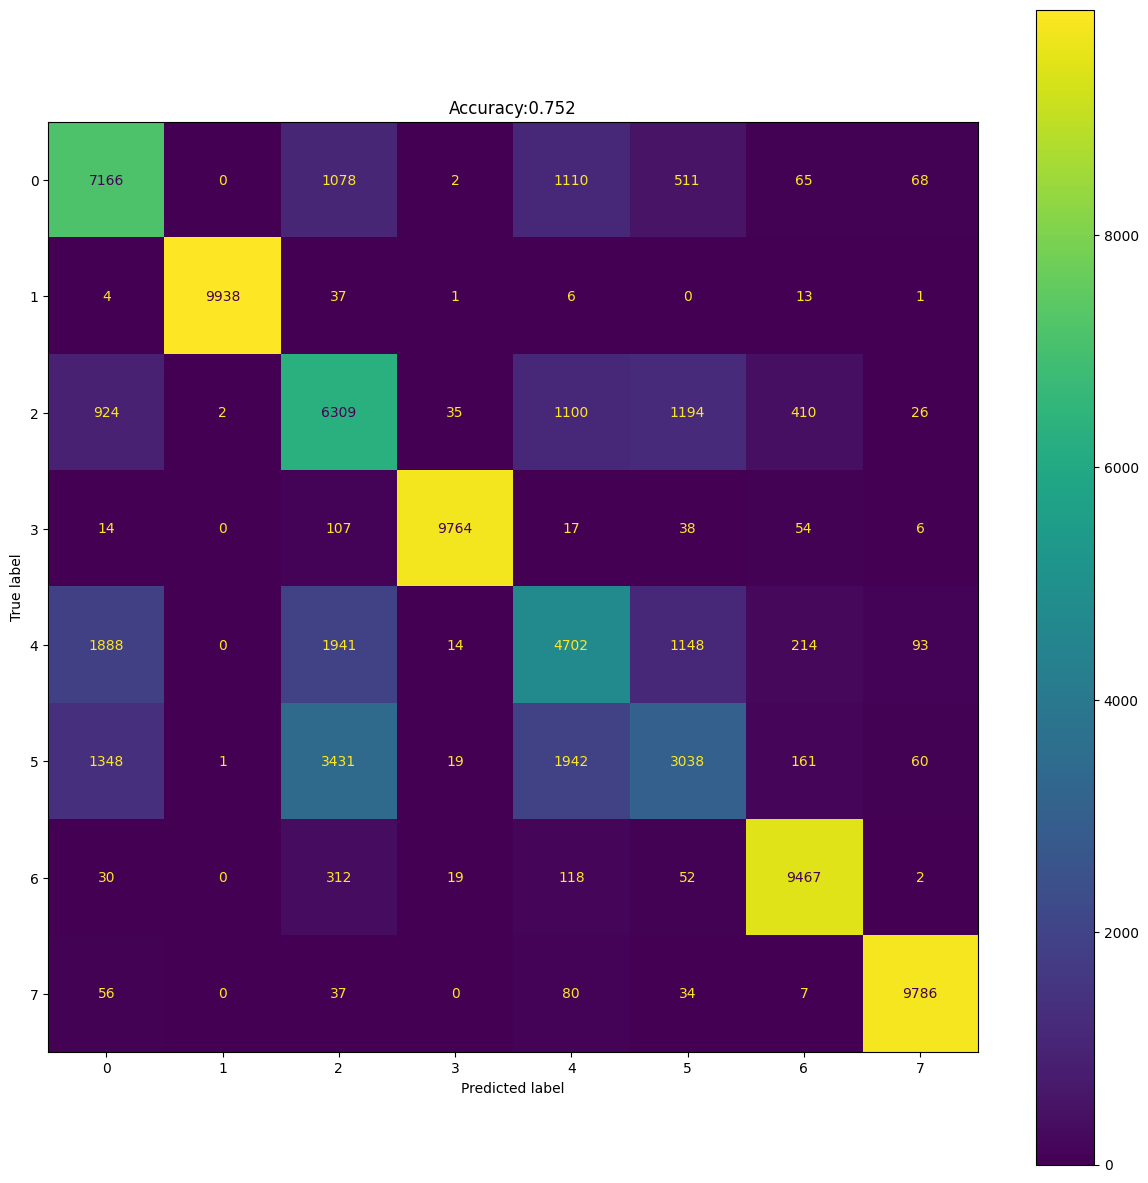

In [105]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')